
##### He Zhu     
#### Email: he.zhu@uconn.edu          

### 1. Machine Learning and Its Application in Stock Price Predicting

This part focuses on binary prediction of direction in asset price movement. To develop this topic, my report will includes 5 parts. 

1.1 $\text{basic logic}$ 

1.2 $\text{Logistic Classifier}$ 
    
    1.2.1 Introduction to Logistic Regression
    1.2.2 Logistic Regression on Simple Lagged Return Features
    1.2.3 Model Validation
        1.2.3.1 K-Fold Cross Valiation
        1.2.3.2 AUC Valiation
        1.2.3.3 Confusion Matrix
        1.2.3.4 Coefficient Analysis
    1.2.4 Extension I: Softmax Regression as Multinomial Logistic Regression
        1.2.4.1 Generalized Linear Model
            I.Bernoulli Distribution of Exponential Family Distribution
            II.Gaussian Distribution of Exponential Family Distribution
        1.2.4.2 General Approach to Construct GLM
            I.From GLM to OLS
            II.From GLM to Logistic Regression
        1.2.4.3 GLM and Softmax Regression*
            I.From GLM to Softmax Regression
            II.Softmax Regression Implementation and Validation 
    1.2.5 Extension II: Robust Model with Additional Features
        1.2.5.1 Feature Construction
        1.2.5.2 Model Validation
        
1.3 $\text{Naive Bayesian Classifier}$ 

    1.3.1 Generative Learning Algorithm and Discriminative Algorithm
    1.3.2 Gaussian Naive Bayes Classifier
        I.Derivation
        II.Model Construction and Validation
    1.3.3 Bernoulli Naive Bayes Classifier
        I.Derivation
        II.Model Construction and Validation
1.4  $\text{Support Vector Machines}$ 
    
    1.4.1 Introduction to Support Vector Machine
    1.4.2 Linear Kernel SVM
        I.Soft Margin
        II.Hard Margin
        III. Analysis
    1.4.3 Polynomial Kernel SVM

1.5 $\text{Decision Tree Classifier}$

    1.5.1 Introduction
    1.5.2 Implementation
    1.5.3 Analysis
    
For better developing my report, all the parts will be equipped with necessary mathematical background.

For the development of my research report, I decided to choose three stocks in the same industry, they are VMW, MSFT and ORCL. They are all from Software-Infrastructure based on Yahoo Finance Stock Profile Data. Also, we have other data source, such as Morning Star, to determine their each industry.

#### 1.1 Introduction and Basic Logics
In this report, we will first design several features, or factors , such as Return Sign, OHLC, Momentum, Moving Average, Exponential MA.
Besides from those simple factors, I will develop some more complicated and advanced features and regimes under which our features may be stronger.At last, we will backtest our models one by one.

Now, let us start coding! We will first design some functions and import some Python modules we will use later.

##### Import Modules

In [4]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

##### We first Read data into Python Pandas Dataframe

In [6]:
VMW = pd.DataFrame(web.DataReader('VMW',data_source = 'yahoo'))
MSFT = pd.DataFrame(web.DataReader('MSFT',data_source ='yahoo'))
ORCL = pd.DataFrame(web.DataReader('ORCL',data_source = 'yahoo'))
VMW.head(3)

High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2010-01-04  43.799999  43.000000  43.150002  43.570000  1104400.0  36.194626
2010-01-05  45.500000  43.189999  43.720001  45.250000  2382600.0  37.590240
2010-01-06  46.459999  45.060001  45.330002  45.669998  2046800.0  37.939144


We will first focus on feature constructions

Here I provide a function to generate a dataframe with several days' lagged returns

In [7]:
def getLaggedReturns(df,lags = 5, window_length = 1):
    #df: pandas Dataframe type variable, and column 'Close' should be included
    #lags: how many lagged returns do you want
    #window_length: the window length we use to compute each return
    laggedReturns =pd.DataFrame(index = df.index)
    laggedReturns['Close'] = df['Close']
    laggedReturns['ret_0'] = np.log(laggedReturns['Close']/laggedReturns['Close'].shift(window_length))
    
        
    for lag in range( 1,lags + 1 ):
        col = 'ret_%d'%lag
        laggedReturns[col] = laggedReturns['ret_0'].shift(lag)
    laggedReturns.dropna(inplace = True)
    
    return laggedReturns

Sometimes the window-length of the return can also influence the model's robustness, for example, the weekly return maybe stronger when predicting mid-term price directions. But the point is that it is tough to determine what window-length to use. So this function adapt the parameter window_length to make our function more flexible.

Now let us turn to use this function to get lagged returns. Here we use window_length = 1 and lags = 5, which means that the return of stocks is computed in daily frequency and 6 lagged returns will be computed.(ret_0 means the most recent daily return)

In [8]:
VMW_laggedReturns = getLaggedReturns(VMW)
MSFT_laggedReturns = getLaggedReturns(MSFT)
ORCL_laggedReturns = getLaggedReturns(ORCL)
#Print one dataframe to make sure our data is correctly structured
VMW_laggedReturns.head(3)

Close     ret_0     ret_1     ret_2     ret_3     ret_4  \
Date                                                                      
2010-01-12  44.630001 -0.004471 -0.009325  0.002434 -0.011673  0.009239   
2010-01-13  45.439999  0.017986 -0.004471 -0.009325  0.002434 -0.011673   
2010-01-14  47.450001  0.043284  0.017986 -0.004471 -0.009325  0.002434   

               ret_5  
Date                  
2010-01-12  0.037834  
2010-01-13  0.009239  
2010-01-14 -0.011673

Fully armed with these factors we can start our first model, the simple logistic model. More features will be created later but up to now I just stop here and I would like to turn to our first model.

#### 1.2 Logistic Regression

##### 1.2.1 Introduction to Binary Logistic Regression

Logistic is a $supervised$ $learning$ algorithm for $binary$ $classification$, where we usually make y can only be assigned with two values, 0 and 1. We can understand logistic regression in multiple aspects. 

For example you can understand logistic regression by regarding it as the $transformation$ from the OLS Linear Regression into $[0,1]$; 

More generally, you can understand it as a special form of the $posterior$ if some conditional distributional $P(x|y)$ is from $exponential$ $family$, where $x$ means input features, and $y$ is output, 0 or 1. For example, we can prove that one another classification method $Gaussian$ $Discriminative$ $Analysis$ can be converted into a logistic regression form mathematically. We can even prove that logistic regression can be constructed using $Generalized$ $Linear$ $Model$ where we usually assume the conditional distribution of output $y$ given x follows $Bernoulli$ $Distribution$, which is one of exponential family distribution.

All in all, we can derive and understand logistic in many ways, but the most important part we need to keep in mind that Logistic Regression Model is a robust model without strong distribution assumptions and a model from more generalized models.

Let us first have an easy impression on Logistic Regression Model's mathematical formula:

$$h_{\theta}(x) = g(\theta ^{T}x) = \frac{1}{1+e^{-\theta^{T}x}} \ \ \ \ \ \ \ \ (1)$$

As I mentioned before, logistic regression can be regarded as a transformation form of linear regression into value $[0,1]$, here as we can see, the value $-\theta^{T}x$ is actually a linear regression prediction. If $-\theta^{T}x$ is $0$, we can say that the predicted $-\theta^{T}x$ given a training set $x$ is on the decision boundary, and our $h_{\theta}(x) = g(\theta^{T}x)=0.5$, so we cannot determine which classification to put this sample. 

For the same reason we can conclude that 

as $-\theta^{T}x \to \infty$, our $h_{\theta}(x) \to 0$ and our predicted point will be deeper located in the class labeled with 0.

as $-\theta^{T}x \to -\infty$, our $h_{\theta}(x) \to 1$ and our predicted point will be deeper located in the class labeled with 1.


We can also regard $h_{\theta}(x)$ as a pseudo-distribution 

when $h_{\theta}(x) > 0.5$, we just say that the probability that the sample belongs to class 1 is larger, we simply put it into class 1, thus giving output $y=1$ 

when $h_{\theta}(x) < 0.5$, we just say that the probability that the sample belongs to class 1 is smaller, we simply put it into class 0, thus giving output $y=0$ 

So we can summarize that

$$
\begin{equation}
y = \begin{cases}
1, & \text{if } h_{\theta}(x) > 0.5;\\
0, & \text{if }h_{\theta}(x) < 0.5;
\end{cases}
\end{equation}
$$

The most usual way we use to fit parameters to a model is to use $Maximum$ $Likelihood$ $Estimation$. For estimation of parameters of logistic regression, we will use this method, too. But this time we will just stop by giving a Likelihood Function of Logistic Regression and the way by which we can approximate our parameters will only be mentioned but not developped. 

First, based on our discusson before, it is very natural to assume that

$$p(y=1| x;\theta) = h_{\theta}(x)$$

$$p(y = 0|x;\theta) = 1- h_{\theta}(x)$$

It will be a good habit to compact them together, then we get 

$$p(y|x;\theta) = (h_{\theta}(x))^{y}((1-h_{\theta}(x))^{1-y} \ \ \ \ \ \ \ (4)$$

Second, a very important assumption is needed. We assume that here are n training examples were independently generated. Only based on this strong assumption, we can product each sample's probability density function together to get our Maximum Likelihood Function. Now let us write it down:

$$L(\theta) = \prod^{n}_{i=1}p(y^{(i)}|x^{(i)};\theta)$$
$$=\prod^{n}_{i = 1}(h_{\theta}(x^{(i)}))^{y{(i)}}(1-h_{\theta}(x^{(i)}))^{1-y^{(i)}}$$

then we can easily get our log-likelihood function:

$$l(\theta) = logL(\theta)$$
$$ = \sum_{i=1}^{n}y^{(i)}logh(x^{(i)})+(1-y^{(i)})log(1-h(x^{(i)})) \ \ \ \ \ \ (5)$$

Now if we want to fit our $\theta$, we only need to $maximize$ $l(\theta)$. There are many methods can be used to maximize this function, such as Batch Gradient Descent Algorithm, Stochastic Gradient Descent Algorithm, Newton Methods and more. I will not discussed them here but will attach them in $Appendices$

##### 1.2.2 Logistic Model on Simple Lagged Return Features
We have previously created our first simple features Lagged Returns, now let use them as our first features to create our first classification model to predict stock price movement direction.

In [9]:
#import sklearn module for logistic regression
from sklearn import linear_model
#Create a list to store independent variables' keys
#Please remember that this list does not include 'ret_0' because our target is to predict 'ret_0' 
cols = ['ret_1', 'ret_2', 'ret_3', 'ret_4', 'ret_5']
#Here 'lbfgs' is a quasi-Newton method which we will not discuss more in this report
#LogisticRegression Type Object of Sklearn are created
lm_VMW = linear_model.LogisticRegression(C = 1e6,solver='lbfgs',multi_class='ovr',penalty='l2')
lm_MSFT = linear_model.LogisticRegression(C = 1e6,solver='lbfgs',multi_class='ovr',penalty='l2')
lm_ORCL = linear_model.LogisticRegression(C = 1e6,solver='lbfgs',multi_class='ovr',penalty='l2')

For $\text{Binary Logistic Classfication}$ Case, we need to notice that y can be only assigned with 1 or 0. So here we need to make the returns those larger than 0 to be 1 and less than or equal to 0 to be 0.

In [10]:
#So we first determine the direction of return for each ret_0
#Then we make those <0 to be = 0
VMW_laggedReturns['Sign']= np.sign(VMW_laggedReturns['ret_0'])
VMW_laggedReturns['Sign'][VMW_laggedReturns['Sign']<0] =0

MSFT_laggedReturns['Sign']= np.sign(MSFT_laggedReturns['ret_0'])
MSFT_laggedReturns['Sign'][MSFT_laggedReturns['Sign']<0] =0

ORCL_laggedReturns['Sign']= np.sign(ORCL_laggedReturns['ret_0'])
ORCL_laggedReturns['Sign'][ORCL_laggedReturns['Sign']<0] =0

In [11]:
###Fit our data using Lagged ret_1, ret_2, ret_3, ret_4, ret_5 with Output Sign +1 or -1
lm_VMW.fit(VMW_laggedReturns[cols],VMW_laggedReturns['Sign'])
lm_MSFT.fit(MSFT_laggedReturns[cols], MSFT_laggedReturns['Sign'])
lm_ORCL.fit(ORCL_laggedReturns[cols],ORCL_laggedReturns['Sign'])

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [12]:
###Now we using our model to do prediction
VMW_laggedReturns['Logit_Predict'] = lm_VMW.predict(VMW_laggedReturns[cols])
MSFT_laggedReturns['Logit_Predict'] = lm_MSFT.predict(MSFT_laggedReturns[cols])
ORCL_laggedReturns['Logit_Predict'] = lm_ORCL.predict(ORCL_laggedReturns[cols])
MSFT_laggedReturns.head(4)

Close     ret_0     ret_1     ret_2     ret_3     ret_4  \
Date                                                                      
2010-01-12  30.070000 -0.006629 -0.012802  0.006873 -0.010454 -0.006156   
2010-01-13  30.350000  0.009269 -0.006629 -0.012802  0.006873 -0.010454   
2010-01-14  30.959999  0.019899  0.009269 -0.006629 -0.012802  0.006873   
2010-01-15  30.860001 -0.003235  0.019899  0.009269 -0.006629 -0.012802   

               ret_5  Sign  Logit_Predict  
Date                                       
2010-01-12  0.000323   0.0            1.0  
2010-01-13 -0.006156   1.0            1.0  
2010-01-14 -0.010454   1.0            1.0  
2010-01-15  0.006873   0.0            0.0

Now as we can see the column 'Logit_Predict' will give us our prediction for future price movement. Here we still need a small modification on this column. I will set the 0's in this column back to be -1, then we can use this measure to better estimate future price movement  

In [13]:
VMW_laggedReturns['Logit_Predict'][VMW_laggedReturns['Logit_Predict']==0] = -1
MSFT_laggedReturns['Logit_Predict'][MSFT_laggedReturns['Logit_Predict']==0] = -1
ORCL_laggedReturns['Logit_Predict'][ORCL_laggedReturns['Logit_Predict']==0] = -1
MSFT_laggedReturns.head(4)

Close     ret_0     ret_1     ret_2     ret_3     ret_4  \
Date                                                                      
2010-01-12  30.070000 -0.006629 -0.012802  0.006873 -0.010454 -0.006156   
2010-01-13  30.350000  0.009269 -0.006629 -0.012802  0.006873 -0.010454   
2010-01-14  30.959999  0.019899  0.009269 -0.006629 -0.012802  0.006873   
2010-01-15  30.860001 -0.003235  0.019899  0.009269 -0.006629 -0.012802   

               ret_5  Sign  Logit_Predict  
Date                                       
2010-01-12  0.000323   0.0            1.0  
2010-01-13 -0.006156   1.0            1.0  
2010-01-14 -0.010454   1.0            1.0  
2010-01-15  0.006873   0.0           -1.0

Here we need a very strong assumption that once we get our predicted price movement direction, we assume that the next-day's return follows 

$$R_{t+1} = LogitPredic * R_{t}$$

which means if $LogitPredict = 1$ then the price movement direction will not change but if $LogitPredict = -1$, the price movement direction will change, and next day's return's absolute value keep same with the day before.

In [14]:
VMW_laggedReturns['Logit_Returns'] = VMW_laggedReturns['Logit_Predict'] * VMW_laggedReturns['ret_0']
MSFT_laggedReturns['Logit_Returns'] = MSFT_laggedReturns['Logit_Predict'] * MSFT_laggedReturns['ret_0']
ORCL_laggedReturns['Logit_Returns'] = ORCL_laggedReturns['Logit_Predict'] * ORCL_laggedReturns['ret_0']
VMW_laggedReturns.head(3)

Close     ret_0     ret_1     ret_2     ret_3     ret_4  \
Date                                                                      
2010-01-12  44.630001 -0.004471 -0.009325  0.002434 -0.011673  0.009239   
2010-01-13  45.439999  0.017986 -0.004471 -0.009325  0.002434 -0.011673   
2010-01-14  47.450001  0.043284  0.017986 -0.004471 -0.009325  0.002434   

               ret_5  Sign  Logit_Predict  Logit_Returns  
Date                                                      
2010-01-12  0.037834   0.0            1.0      -0.004471  
2010-01-13  0.009239   1.0            1.0       0.017986  
2010-01-14 -0.011673   1.0            1.0       0.043284

Now we will use our predicted return to plot our Net Asset Value change!

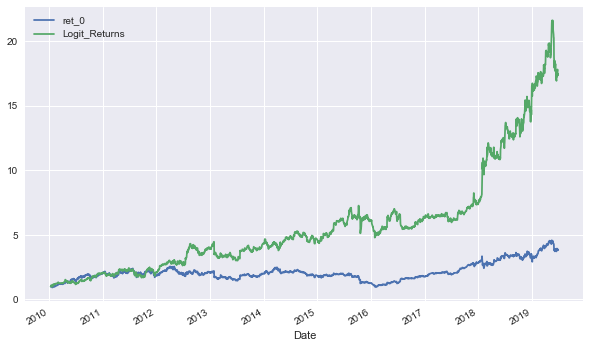

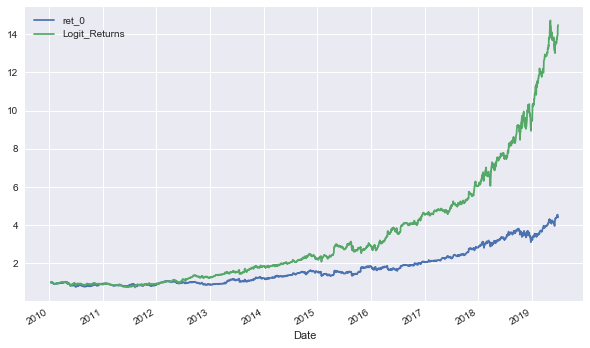

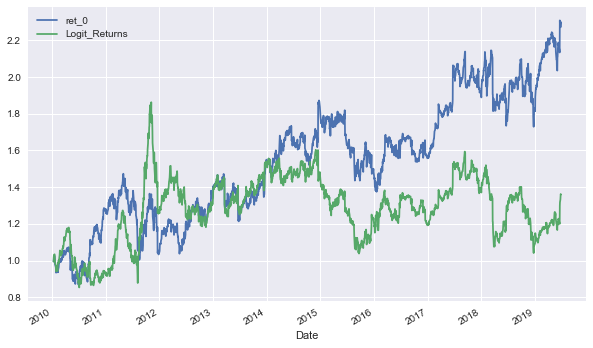

In [15]:
VMW_laggedReturns[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));
MSFT_laggedReturns[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));
ORCL_laggedReturns[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));

As we can see in these three figures, our estimation usually will overestimate stocks' future performance though the rough direction estimation is correct. We can say our model acctually predict the price movement direction.
#### No Training Set and Validation Set!!! 
But here exist a big danger in our model! We did not divide our dataset into $training$ $set$ and $validation$ $set$! Now I will divide our data set into two date set. We will use 70% of dataset as training set and 30% of dataset as validation set

In [16]:
#We need to note that all these 3 stocks have the same rows,or say that the same number of datasets 
num_training = int(0.7*VMW.shape[0])
train_VMW = VMW_laggedReturns.iloc[0:num_training,:]
train_MSFT = MSFT_laggedReturns.iloc[0:num_training,:]
train_ORCL = ORCL_laggedReturns.iloc[0:num_training,:]
test_VMW = VMW_laggedReturns.iloc[num_training:,:]
test_MSFT = MSFT_laggedReturns.iloc[num_training:,:]
test_ORCL = ORCL_laggedReturns.iloc[num_training:,:]

In [17]:
###Fit our data agian
lm_VMW.fit(train_VMW[cols],train_VMW['Sign'])
lm_MSFT.fit(train_MSFT[cols],train_MSFT['Sign'])
lm_ORCL.fit(train_ORCL[cols],train_ORCL['Sign'])

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [18]:
#We predict our output Y
test_VMW['Logit_Predict'] = lm_VMW.predict(test_VMW[cols])
test_MSFT['Logit_Predict'] = lm_MSFT.predict(test_MSFT[cols])
test_ORCL['Logit_Predict'] = lm_ORCL.predict(test_ORCL[cols])

In [19]:
#As we did before, we need to set 'Logit_Predict' =0 to be -1
test_VMW['Logit_Predict'][test_VMW['Logit_Predict']==0] = -1
test_MSFT['Logit_Predict'][test_MSFT['Logit_Predict']==0] = -1
test_ORCL['Logit_Predict'][test_ORCL['Logit_Predict']==0] = -1

#Overwritting the previous data
test_VMW['Logit_Returns'] =test_VMW['ret_0']*test_VMW['Logit_Predict']
test_MSFT['Logit_Returns'] =test_MSFT['ret_0']*test_MSFT['Logit_Predict']
test_ORCL['Logit_Returns'] =test_ORCL['ret_0']*test_ORCL['Logit_Predict']
###Dont worry about warnings, it won't influence our analysis
test_VMW.head()

Close     ret_0     ret_1     ret_2     ret_3     ret_4  \
Date                                                                      
2016-08-30  74.220001 -0.013516  0.013112 -0.003764 -0.002145  0.001742   
2016-08-31  73.330002 -0.012064 -0.013516  0.013112 -0.003764 -0.002145   
2016-09-01  73.779999  0.006118 -0.012064 -0.013516  0.013112 -0.003764   
2016-09-02  73.779999  0.000000  0.006118 -0.012064 -0.013516  0.013112   
2016-09-06  73.389999 -0.005300  0.000000  0.006118 -0.012064 -0.013516   

               ret_5  Sign  Logit_Predict  Logit_Returns  
Date                                                      
2016-08-30  0.020049   0.0           -1.0       0.013516  
2016-08-31  0.001742   0.0            1.0      -0.012064  
2016-09-01 -0.002145   1.0            1.0       0.006118  
2016-09-02 -0.003764   0.0            1.0       0.000000  
2016-09-06  0.013112   0.0            1.0      -0.005300

Now with seperate train set and validation set, we start to see the result of our model

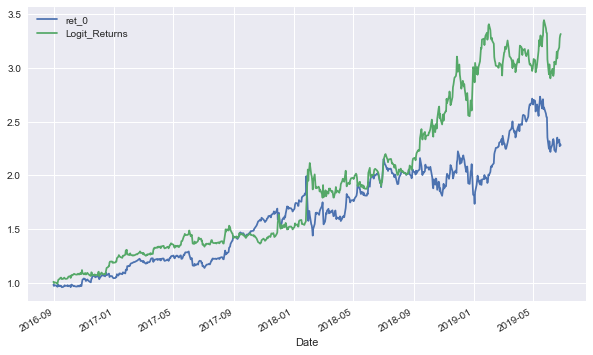

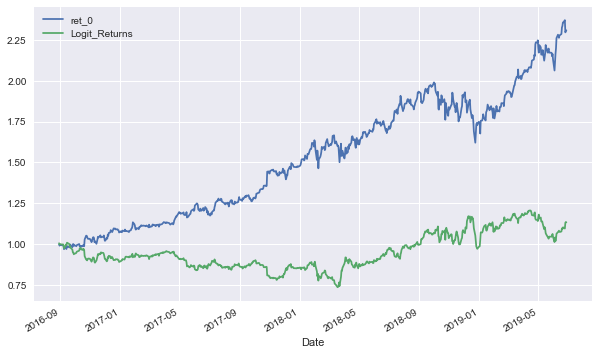

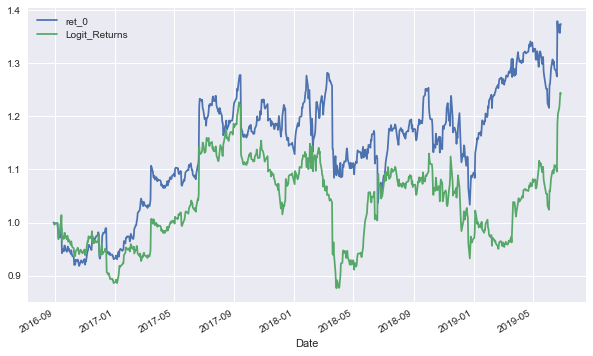

In [20]:
test_VMW[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));
test_MSFT[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));
test_ORCL[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));

##### Transition Probability 
Though we have got our price prediction paths and it seems good, it can be better if we can get a transition probability of our model. Transition probability can help us discover the probability of a stock's price going up or down. It is simple to implement it using existing modules.

In [21]:
lm_VMW.predict_proba(train_VMW[cols])
lm_MSFT.predict_proba(train_MSFT[cols])
lm_ORCL.predict_proba(train_ORCL[cols])

array([[0.49047305, 0.50952695],
       [0.46994383, 0.53005617],
       [0.49007448, 0.50992552],
       ...,
       [0.46832692, 0.53167308],
       [0.50105321, 0.49894679],
       [0.48048096, 0.51951904]])

Here we compute Correlation between real series and predicted series. They will be used later for comparison with Multinomial Logit Regression Model

In [22]:
test_VMW['real_NAV'] = test_VMW['ret_0'].cumsum().apply(np.exp)
test_VMW['real_NAV'] = test_VMW['ret_0'].cumsum().apply(np.exp)
test_VMW['predicted_NAV'] = test_VMW['Logit_Returns'].cumsum().apply(np.exp)
np.corrcoef(test_VMW['real_NAV'],test_VMW['predicted_NAV'])

array([[1.       , 0.9148953],
       [0.9148953, 1.       ]])

In [23]:
test_MSFT['real_NAV'] = test_MSFT['ret_0'].cumsum().apply(np.exp)
test_MSFT['predicted_NAV'] = test_MSFT['Logit_Returns'].cumsum().apply(np.exp)
np.corrcoef(test_MSFT['real_NAV'],test_MSFT['predicted_NAV'])

array([[1.        , 0.61346842],
       [0.61346842, 1.        ]])

In [24]:
test_ORCL['real_NAV'] = test_ORCL['ret_0'].cumsum().apply(np.exp)
test_ORCL['predicted_NAV'] = test_ORCL['Logit_Returns'].cumsum().apply(np.exp)
np.corrcoef(test_ORCL['real_NAV'],test_ORCL['predicted_NAV'])

array([[1.        , 0.65374158],
       [0.65374158, 1.        ]])

Here the left-most and the right-most value mean the probability output is -1 or 1. Most of transition probabilities are around 0.5, which are not very good results.

#### 1.2.3 Model Validation
Now with the seperation of training set and test set, our model still performs good in price movement direction prediction, but actually how good it is? Now I would like to introduce three mainly used model validation techniques to you. They are

(1) Cross-Validation, and in this report, K-Fold Cross validation will be developed

(2) AUC Validation, or Area under ROC curve validation.

(3) Confusion Matrix Validation, 

##### 1.2.3.1 K-Fold Cross Validation
Cross Validation is kind of out-of-sampling testing technique used to backtest how accurately our predictive model perform. Conventionally, our dataset is usually divided into two parts, training part and testing part, and cross validation is to test how good will our model perform in testing set with estimation from training set.

The basic steps of cross validation are

(1)First, we partite our data into complementary sets.Strictly speaking, there are no limit of set number, and we can partite our data set into thounsands part for backtesting if our dataset is large enough.

(2)Second, we choose one set as our training set to train our model

(3)Third, Test our model by running it on multiple different model

(4)Put our backtesting result together and average our backtesting result

There are many types of cross-validation techniques we usually use. Roughly we can seperate them into two types. 

The first type is Exhaustive Cross-Validation techniques, which try to train and test our model on all possible subsets. 

The second type is Non-Exhaustive Cross-Validation, which can be regarded as an approximation and simplicity of exhaustive validation, because we don't want to catch all possible validation possibilities. I won't talk more about details here. 

More information about cross-validation will be attached at appendices.


In this report, I will use a validation method called $k-fold$ $crossvalidation$ method. This method requires us to split our data set into K number of consecutive sections, and (k-1) subsets are used to train the model and the remained one is used to test our data. We will have k validation rounds and in each round, one subset plays the role of testing set and others plays the roles of training set. At last we can compute our Final Accuray by average our individual accuracy ratio  

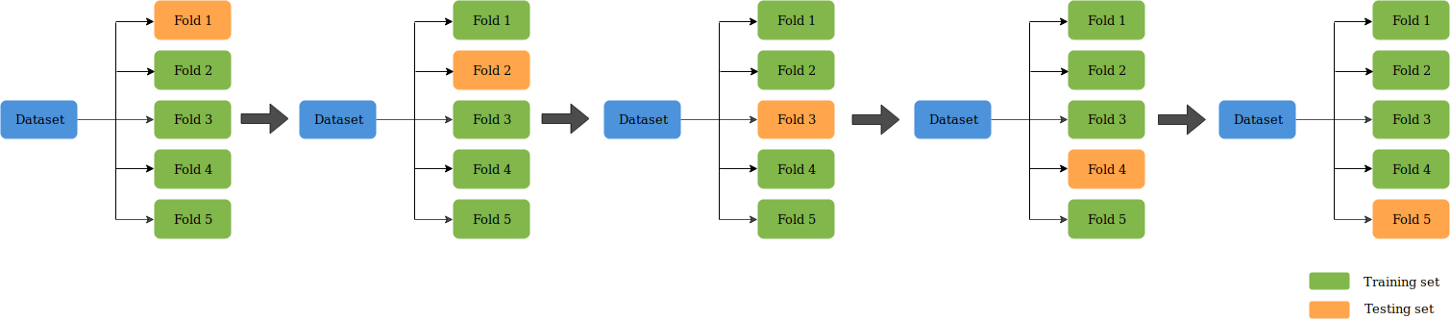
Figure Source : 
https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833

In [25]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#We first create a KFold object, and we define the number of sections to be 5
#Here shuffle= True means we will shuffle our data, or in other words, randomly sort it, before our split 
kfold = KFold(n_splits = 5,random_state=7,shuffle = True)
print(kfold)

KFold(n_splits=5, random_state=7, shuffle=True)


In [26]:
VMW_laggedReturns.iloc[:,:].head()

Close     ret_0     ret_1     ret_2     ret_3     ret_4  \
Date                                                                      
2010-01-12  44.630001 -0.004471 -0.009325  0.002434 -0.011673  0.009239   
2010-01-13  45.439999  0.017986 -0.004471 -0.009325  0.002434 -0.011673   
2010-01-14  47.450001  0.043284  0.017986 -0.004471 -0.009325  0.002434   
2010-01-15  45.919998 -0.032776  0.043284  0.017986 -0.004471 -0.009325   
2010-01-19  46.689999  0.016629 -0.032776  0.043284  0.017986 -0.004471   

               ret_5  Sign  Logit_Predict  Logit_Returns  
Date                                                      
2010-01-12  0.037834   0.0            1.0      -0.004471  
2010-01-13  0.009239   1.0            1.0       0.017986  
2010-01-14 -0.011673   1.0            1.0       0.043284  
2010-01-15  0.002434   0.0           -1.0       0.032776  
2010-01-19 -0.009325   1.0            1.0       0.016629

In [27]:
###Now we get the number of splitting iterations in the cross-validator
kfold.get_n_splits(VMW_laggedReturns.iloc[:,2:7])

#We first cross-validate our VMW logit model
logit_VMW = linear_model.LogisticRegression(C=1e5,solver ='lbfgs',multi_class='auto',penalty='l2')
logit_VMW.fit(VMW_laggedReturns.iloc[:,2:7],VMW_laggedReturns['Sign'])
crossval_VMW = cross_val_score(logit_VMW,VMW_laggedReturns.iloc[:,2:7],VMW_laggedReturns['Sign'],cv=kfold,scoring = 'accuracy')
print("5-Fold Cross Validation Accuracy For VMW Logit Model: %.4f"%crossval_VMW.mean())

#We second cross-validate our MSFT logit model
logit_MSFT = linear_model.LogisticRegression(C=1e5,solver ='lbfgs',multi_class='auto',penalty='l2')
logit_MSFT.fit(MSFT_laggedReturns.iloc[:,2:7], MSFT_laggedReturns['Sign'])
crossval_MSFT = cross_val_score(logit_MSFT,MSFT_laggedReturns.iloc[:,2:7],MSFT_laggedReturns['Sign'],cv=kfold,scoring = 'accuracy')
print("5-Fold Cross Validation Accuracy For MSFT Logit Model: %.4f"%crossval_MSFT.mean())

#We second cross-validate our ORCL logit model
logit_ORCL = linear_model.LogisticRegression(C=1e5,solver ='lbfgs',multi_class='auto',penalty='l2')
logit_ORCL.fit(ORCL_laggedReturns.iloc[:,2:7], ORCL_laggedReturns['Sign'])
crossval_ORCL = cross_val_score(logit_ORCL,ORCL_laggedReturns.iloc[:,2:7],ORCL_laggedReturns['Sign'],cv=kfold,scoring = 'accuracy')
print("5-Fold Cross Validation Accuracy For MSFT Logit Model: %.4f"%crossval_ORCL.mean())

5-Fold Cross Validation Accuracy For VMW Logit Model: 0.5145
5-Fold Cross Validation Accuracy For MSFT Logit Model: 0.5221
5-Fold Cross Validation Accuracy For MSFT Logit Model: 0.5166


As we can see in result, our models are accurate enough, which means if we are interesting in doing intra-day trading, our algorithm can be very profitable. Now I will talk about one another validation techniques.

##### 1.2.3.2 AUC Validation

Let us first briefly have a basic concept of AUC validation. AUC is the abbreviation of Area under ROC curve, where ROC is the abbreviation of Receiver Operating Characteristic Curve.

ROC plots the relationship between True Positive Rate (TPR) and False Positive Rate(FPR), where

$$TPR = \frac{TP}{TP + FN}$$ 

$$FPR = \frac{FP}{FP + TN}$$
 
Here we meet many abbreviation which may confuse us much, so you can take a look at the figure below
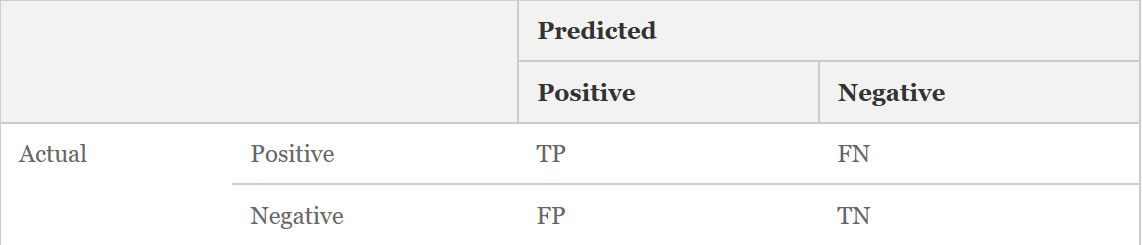

Figure Source : https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-9863-7_255

So in a binary classification problem, if the actual outcome should be positive and our predicted outcome is also positive, then we can say this predicted output is True Positive, then we can conclude that here $TF$ means the number of True Positive predicted output. Other three abbreviations also follow this rule.  


One of the best way to understand AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, we have following figures, where examples are arranged from left to right in ascending order of logit regression predictions:
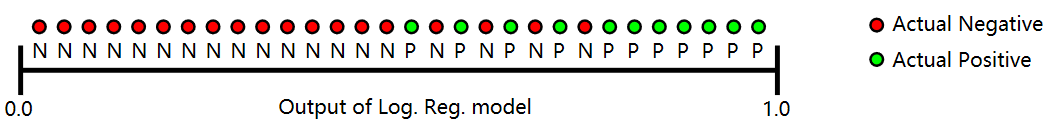

Figure Source:https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-9863-7_255

We can imagine that if a logit regression model rank samples in right order, the True Positive Rate will increase faster than False Positve Rate, thus the area under ROC curve is larger and grows faster to 1. You can understand it using very extreme circumstance where there are no false examples, which means that FN = 0 and FP = 0, than when FPR = 0 the TPR = 1, and then the ROC will be vertical to horizontal axis. Now let us start coding

$$\text{We first define the function for ROC plotting}$$

In [28]:
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import StratifiedKFold

#we first define a function to plot AUC
def plot_logit_ROC(default_ind,Y_test,X_test,logit,Y_response,X_features):
    #logit: We pass a defined LogisticRegression Object here
    #Y-Response: Y Population
    #X_Features: X Population
    #Y_test: testing set Y
    #X_test: testing set X
    
    # (1) Calculate AUC on testing set
    logit_roc_aucT = roc_auc_score(Y_test, logit.predict(X_test))
    # (2) calculate False Positive Rate and True Positive Rate on test set
    fprT,tprT,thresholdsT = roc_curve(Y_test,logit.predict_proba(X_test)[:,1],pos_label = default_ind)
    
    #(3)Calculate AUC on population testing set
    logit_roc_aucP = roc_auc_score(Y_response,logit.predict(X_features))
    #(4)calculate False Positive Rate and True Positive Rate on Population
    fprP,tprP,threasholdsP = roc_curve(Y_response,logit.predict_proba(X_features)[:,1],pos_label=default_ind)
    
    fig,ax = plt.subplots(figsize=(10,8))
    
    #Plot diagnoal line
    ax.plot([0,1],[0,1],'r--',label = "Random Classifier")
    
    #Plot ROC for predictions on testing set
    ax.plot(fprT,tprT,label = 'Train/Test Regression (area = %0.2f)'%logit_roc_aucT)
    
    #Plot ROC curve for the prediction on full set
    ax.plot(fprP,tprP,label = 'Population Regression (area = %0.2f)'%logit_roc_aucP)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()
    
    return ax

##### VMW ROC & AUC

In [29]:
 from sklearn import model_selection 

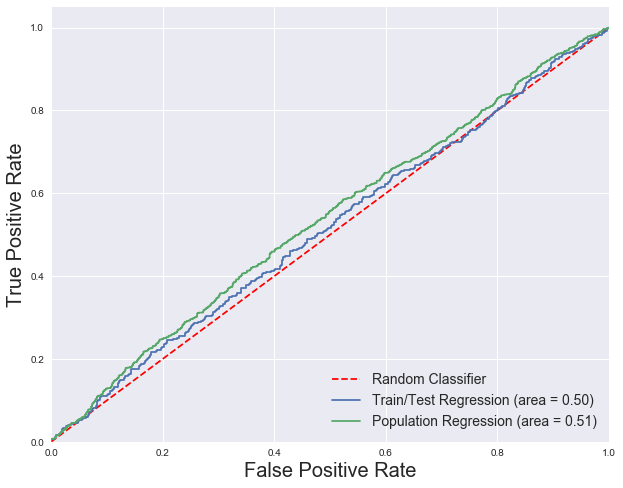

In [30]:
#plot_logit_ROC(default_ind,Y_test,X_test,logit,Y_response,X_features)
X_Train_VMW, X_Test_VMW, Y_Train_VMW, Y_Test_VMW = model_selection.train_test_split(VMW_laggedReturns.iloc[:,2:7],
                                                                                    VMW_laggedReturns['Sign'] ,
                                                                                    test_size=0.6, shuffle=True)
logit_VMW = linear_model.LogisticRegression(C = 1e15,solver ='lbfgs',penalty='l2')
logit_VMW.fit(X_Train_VMW,Y_Train_VMW)
plot_logit_ROC(1,Y_Test_VMW,X_Test_VMW,logit_VMW,VMW_laggedReturns['Sign'],VMW_laggedReturns.iloc[:,2:7])

###Here we plot the ROC and Calculate the AUC of VMW Logit Regression Model

##### MSFT AUC & ROC

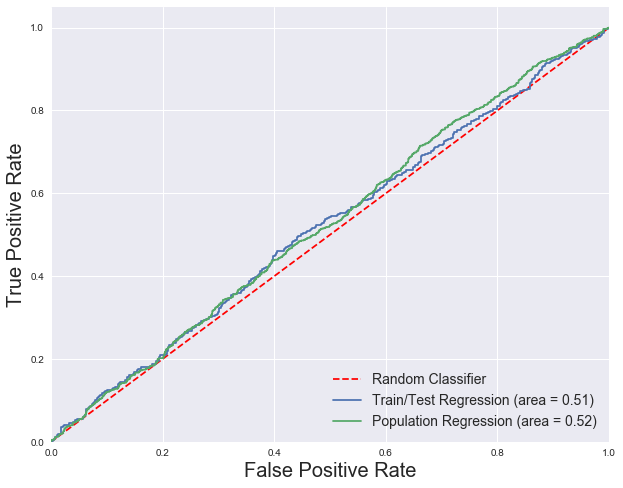

In [31]:
X_Train_MSFT, X_Test_MSFT, Y_Train_MSFT, Y_Test_MSFT = model_selection.train_test_split(MSFT_laggedReturns.iloc[:,2:7],
                                                                                    MSFT_laggedReturns['Sign'],
                                                                                    test_size=0.6, shuffle=True)
logit_MSFT= linear_model.LogisticRegression(C = 1e15,solver ='lbfgs',penalty='l2')
logit_MSFT.fit(X_Train_MSFT,Y_Train_MSFT)
plot_logit_ROC(1,Y_Test_MSFT,X_Test_MSFT,logit_MSFT,MSFT_laggedReturns['Sign'],MSFT_laggedReturns.iloc[:,2:7])

###Here we plot the ROC and Calculate the AUC of MSFT Logit Regression Model

##### ORCL AUC&ROC

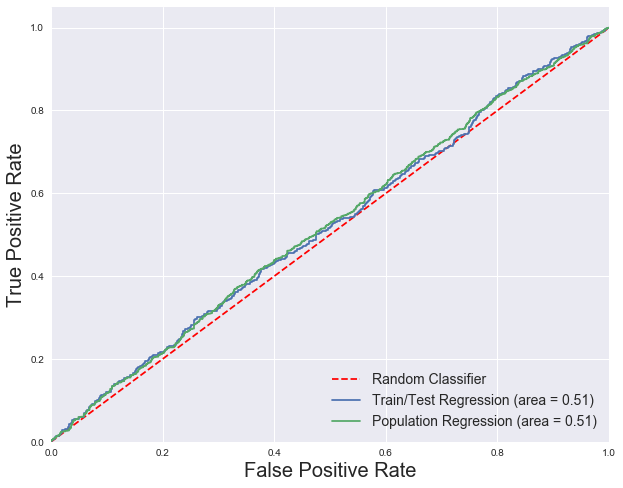

In [32]:
X_Train_ORCL, X_Test_ORCL, Y_Train_ORCL, Y_Test_ORCL = model_selection.train_test_split(ORCL_laggedReturns.iloc[:,2:7],
                                                                                    ORCL_laggedReturns['Sign'],
                                                                                    test_size=0.6, shuffle=True)
logit_ORCL = linear_model.LogisticRegression(C = 1e15,solver ='lbfgs')
logit_ORCL.fit(X_Train_ORCL,Y_Train_ORCL)
plot_logit_ROC(1,Y_Test_ORCL,X_Test_ORCL,logit_ORCL,ORCL_laggedReturns['Sign'],ORCL_laggedReturns.iloc[:,2:7])
###Here we plot the ROC and Calculate the AUC of ORCL Logit Regression Model

So based on our analysis before, we can say that these 3 models are not significantly valid(above 45' line).So we cannot easily belive that this model can help us earn more in stock market

##### 1.2.3.3 Confusion Matrix Validation

Confusion Matrix is one another frequently used validation technique to evaluate classification model's accuracy. Different from AUC validation which focuses more on True Positive Rate and False Positive Rate, confusion matrix focuses more on True Positive Number and True Negative Number.

Let us code it for clear

In [33]:
#First import module we will use for confusion matrix analysis
from sklearn.metrics import confusion_matrix

#Compute Confusion Matrix for VMW Logit Regression Model
Y_VMW_pred = logit_VMW.predict(X_Test_VMW)
confusion_matrix_VMW = confusion_matrix(Y_Test_VMW,Y_VMW_pred)
#Compute Confusion Matrix for MSFT Logit Regression Model
Y_MSFT_pred = logit_MSFT.predict(X_Test_MSFT)
confusion_matrix_MSFT = confusion_matrix(Y_Test_MSFT,Y_MSFT_pred)
#Compute Confusion Matrix for ORCL Logit Regression Model
Y_ORCL_pred = logit_ORCL.predict(X_Test_ORCL)
confusion_matrix_ORCL = confusion_matrix(Y_Test_ORCL,Y_ORCL_pred)

In [34]:
print("VMW Confusion Matrix")
print(confusion_matrix_VMW)
print("MSFT Confusion Matrix")
print(confusion_matrix_MSFT) 
print("ORCL Confusion Matrix")
print(confusion_matrix_ORCL)

VMW Confusion Matrix
[[213 461]
 [232 523]]
MSFT Confusion Matrix
[[ 90 620]
 [ 81 638]]
ORCL Confusion Matrix
[[292 379]
 [322 436]]


Now with these confusion matrix, we can better understand what actually goes on. In each matrix, here are four elements. 

Take VMW confusion matrix as an example, 
1. the upper-left element is the number of True Positive Samples, which is 191, and the right-upper element is the number of False Negative Samples, which is 490. So, the actual postive sample number should be 191 + 490 = 781, and our model catch 191/781 actual positive sample correctly, it is not very ideal.  


2. the lower-left element is the number of False Positive Samples, which is 204, and the right-lower element is the number of True Negative Samples, which is 514. So, the actual negative sample number should be 204 + 542 = 756, and our model catch 204/752 actual positive sample correctly, it is not an  ideal result.

3. Totally, we can find our model tends to regard more samples to be negative, and this phenomenon is absoulutely not occassional, because from all the three confusion matrix, the right side numbers are always higher than those in the left.

#### 1.2.3.4 Coefficient Analysis
The final analysis we will do one logistic regression model is a simple coefficient analysis. We have done model fitting before, so we can easily do some coefficient analysis in several short codes 

In [35]:
print('Coefficient for Logit Regression on VMW : ')
print(logit_VMW.coef_.ravel())
print('Coefficient for Logit Regression on MSFT : ')
print(logit_MSFT.coef_.ravel())
print('Coefficient for Logit Regression on ORCL : ')
print(logit_ORCL.coef_.ravel())

Coefficient for Logit Regression on VMW : 
[-6.18463871 -2.00578299 -8.49971443 -0.32893597 -2.03233178]
Coefficient for Logit Regression on MSFT : 
[-3.68845747 -1.7385331   0.92080559 -3.45536111 -8.57349407]
Coefficient for Logit Regression on ORCL : 
[-1.603202    0.9355141  -2.33091462  1.25068553 -4.92214301]


According to some simple observations, we can conclude that there are no consistent relationship between future price movement with lagged returns among these three stocks.

All in All, based on all the validation and analysis we did before, our models do not perform strong. But it does not mean that classifcation algorithm will always fail in this kind of case. Actually, some models, for example $\text{Multinomial Logistic Model}$, a generalized model of our classical $\text{Binary Logistic Model}$ will perform very strong. I will talk about it in the extension part.

#### 1.2.4 Extension I: Softmax Regression as Multinomial Logistic Regression

Based on our model used before, our model does not perform very strong, but it doest not mean that our model will perform worse in all classfication models. Actually, here exist some more generative form of Logistic Regression Model can make our prediction more accurate.
We call it $\text{Softmax Regression}$，or we can call it $\text{Multinomial Logistic Regression}$.

For better developing Multinomial Logistic Regression, we need first explore one another term called $\text{Generalized Linear Model}$

##### 1.2.4.1 Generalized Linear Model

We know $\text{Ordinary Linear Regression}$, under which we assume $y|x;\theta \sim N(\mu,\sigma^2)$, We also know our classical $\text{Logistic Regression}$, under which we assume $y|x; \theta \sim Bernoulli(\phi)$. Sometimes we may regard them as two different modeling techniques, one for regression and another one for classification, but essentially they both can derived from a more generalized family, $\text{Generalized Linear Models}$

First we need to set the basic format of $\text{Exponential Family Distributions}$, which underlies the GLM.

$$p(y;\eta) = b(y)exp(\eta^{T}T(y)-a(\eta)) \ \ \ \ \ \text{Standard Exponential Family Distribution}$$

The one of the important component is $exp(-a(\eta))$, which is a normalization constant controlling the $p(y;\eta)$ sums/integrates over y to 1

Now with definition of Exponential Familiy Distribution, we can easily show that both Gaussian distribution and Bernoulli distribution are of Exponential Family Ditribution..

$\text{ I.Bernoulli Distribution of Exponential Family Distribution}$

Bernoulli distribution has properties as follows

$$mean = \phi$$

$$p(y=0;\phi) = 1 - \phi$$

$$p(y=1;\phi) = \phi$$

$$p(y;\phi) = \phi^{y}(1-\phi)^{1-y}$$

Now let convert the format of the last unconditional probability function

$$p(y;\phi) = \phi^{y}(1-\phi)^{1-y}$$

$$=exp(ylog\phi +(1-y)log(1-\phi))$$

$$=exp((log\frac{\phi}{1-\phi})y + log(1-\phi))$$

Now let us compare it to the standard exponential family distribution

we can make $\eta = log(\frac{\phi}{1-\phi})$

then we can easily get

$$\phi = \frac{1}{1+exp(-\eta)}$$

this is our frequently met sigmoid function, and with this, we have
$$-log(1-\phi) = -log(1-\frac{1}{1+exp(-\eta)}) = log(1 + e^{\eta})$$

we can regard it as our $a(\eta)$ in the standard exponential family distribution

So up to now, we have our Bernoulli distribution to exponential family distribution where

$$T(y) = y$$

$$a(\eta) = log(1 + e^\eta)$$

$$b(y) = 1$$

$\text{ II.Gaussian Distribution of Exponential Family Distribution}$

When we fit parameters for linear regression with the assumption that $y|x;\theta \sim N(\mu ,\sigma ^ 2)$, the parameter $\sigma^2$, which represent the variance of the distribution will not influence our final fitting result, so for similicity we can fix it to be 1. So we have:

$$p(y;\mu) = \frac{1}{\sqrt{2\pi}}exp(-\frac{1}{2}(y-\mu)^2)$$

$$=\frac{1}{\sqrt{2\pi}}exp(-\frac{1}{2}y^2)exp(\mu y - \frac{1}{2}\mu^2)$$

As we did before, we substitue its elements with standard exponential family distribution, we have:

$$\eta = \mu$$

$$T(y) = y$$

$$a(\eta) = \frac{\mu ^ 2}{2} = \frac{\eta ^ 2}{2}$$

$$b(y) = \frac{1}{\sqrt{2 \pi}}exp(-y^2/2 )$$

For your reference, I also pastes a table which summarize some exponential family distribution we usually use:
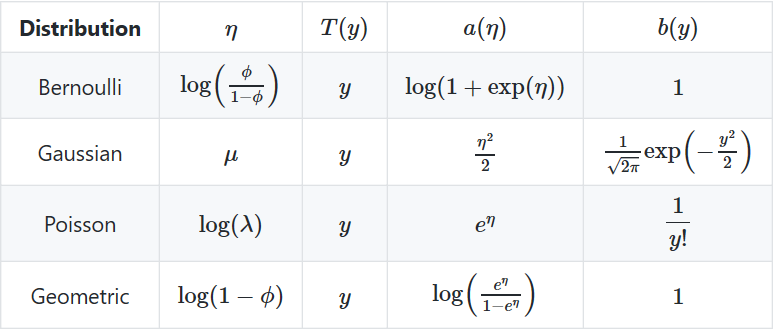

#### 1.2.4.2 General Approach to Construct GLM

Now that we have some bacis knowledge about exponential family distribution, we need to use this distribution for our modeling purpose.We need three important prerequisites or assumptions to make model built:
1. $y|x;\theta \sim Exponential Family(\eta)$

2. $h_\theta(x) = E[T(y)|x;\theta]$;This means given x, our target is to predict the expected value of T(y), or compute  $E[T(y)|x;\theta]$. Because in most cases, $T(y) = y$, so our purpose can be seen as predicting $E[y|x;\theta]$

3. The natural parameter $\eta$ and the inputs x are related linearly: $\eta = \theta ^T x$

With these three assumptions, we can easily derive many learning algorithms, and the resulting models are usually easy for modelling different types of distributions over y. We we derive logistic regression and ordinary least squares as GLMs.

$\text{I. From GLM to OLS}$

Assume that our target variable y is continuous and $y|x;\theta \sim N(\mu,\sigma ^ 2)$, and let us use our standard exponential family distribution $p(y;\eta) = b(y)exp(\eta^{T}T(y)-a(\eta))$ to be the Gaussian distribution.

As we proved before, when we convert Gaussian distribution to be Exponential Family Distribution, we have 
   $$\mu = \eta$$
and because  $y|x;\theta \sim N(\mu,\sigma ^ 2)$, which means $E[y|x;\theta] = \mu$
and again because our assumption 2 we mentioned before, which assumes that 
$$h_{\theta}(x) = E[y|x;\theta]$$

and our assumption 3 which assumes that $\eta = \theta^Tx$,

we can link those evidences together to get 

$$h_{\theta}(x) = E[y|x;\theta]$$

$$=\mu$$

$$=\eta$$

$$=\theta^Tx$$

So up to now, we can say that if we want to use OLS to predict output $h(x)$, we can derive it from GLMs, and our prediction should be $\theta ^T x$

$\text{II. From GLM to Logistic Regression}$

We can intuitively link Logistic Regression with Bernoulli distribution. Because conditional on x, our problem of logistic regression is classifying our output $y$ to be 1 or 0. Now let us trace back our logic used before for linking Gaussian distribution as Exponential Family Distributin with OLS, we now link Logistic Regression with Bernoulli Distribution.

We have previous proved that for a Bernoulli distribution, $E[y|x;\theta] = \phi$. And when we linked Bernoulli Distribution with Exponential Family Distribution, we have shown that $\phi = \frac{1}{1+e^{-\eta}}$. Again we use our assumption 3 that $\eta = -\theta^T x$, we can compact those to get:

$${h_\theta(x) = E[y|x;\theta]}$$

$$=\phi$$

$$=\frac{1}{1+e^{-\eta}}$$

$$=\frac{1}{1+e^{-\theta^Tx}}$$

So finally we get our logistic regression! Now let us arrange our mind again to make clear how do we get Logistic Regression:

1. First, We should be familiar with Exponential family distribution

2. Second, we convert a Bernoulli distribution to be Exponential family distribution

3. Third, we need to come up with 3 assumptions which make GLMs be able to construct models

4. At last, we link assumptions with our Bernoulli distribution which is represented in Exponential family distribution format

5. We finally get the desired logistic regression

Those steps may be important, because almost all the model derived from GLMs can be constructed in this kind of steps

#### 1.2.4.3 GLM and Softmax Regression

At last we can start our Softmax Regression. This regression is also called $\text{Multinomial Logistic Regression}$. Yes, as its name tells us, this model has very interesting relationship with our classical binary logistic regression. Here I summarize their common features for your convenience

1. They can both derived from GLMs
2. They are both used in classfication problems
3. Their formula are very similiar
4. Multinomial Logistic Regression can be regarded as a generalized form of Logistic Regression. Because Multinomial Logistic can be derived from Multinomial distribution, one of Exponential family distribution and the generalized form of Bernoulli distribution, which is the foundation of logistic regression

$\text{I .From GLM to Softmax Regression}$

Now let us start work on the Softmax Regression( Multinomial Logistic Regression).

First let us express our Multinomial distribution as Exponential family distribution:

If we have a multinomial distribution over K possible outcomes, we can use K-1 parameters to specify the probability of each of the outcomes. We can parameterize the Multinomial distribution as followings:
$$\phi_{1},\phi_{2},...,\phi_{k-1}, \text{where } \phi_{i} = p(y =i;\phi)$$
and
$$\phi_{k} =p(y=k;\phi) = 1 - \sum^{k-1}_{i=1}\phi_i$$

Now we define $T(y)\in R^{k-1}$ as follows:

$$T(1) = \begin{bmatrix} 1\\ 0 \\ 0 \\ .\\ .\\ 0 \end{bmatrix}, T(2) = \begin{bmatrix} 0 \\ 1 \\ 0 \\ .\\ .\\ 0 \end{bmatrix},..., T(K-1) = \begin{bmatrix} 0 \\ 0 \\ 0 \\ .\\ .\\ 1 \end{bmatrix}, T(K) = \begin{bmatrix} 0\\ 0 \\ 0 \\ .\\ .\\ 0 \end{bmatrix}$$

We need to notice that now $T(y)'s$ are not equal to $y$ anymore but vectors with dimension equal to $K-1$

And now we will use $(T(y))_i$ to denote the i-th element of the vector T(y).

Actually, we have $$(T(y))_i = 1{\{y=i\}}$$

where $$1\{True\} = 1,1\{False\} = 0, $$

It is very important for us to have a real understand what does $(T(y))_i = 1{\{y=i\}}$ mean, I will explain it here:

Now you choose a vector, for example $T(2)$, then we have $y = 2$. 

And then if you want to determine the i-th element's value in the vector, you can use $(T(2))_i = 1{\{2=i\}}$ 

Now, you can easily understand what is going on about this notation:

$$\text{if i = 2, then we get 1}$$
$$\text{if i} \neq \text{2, then we get 0}$$

Further, we have 

$$E[(T(y))_i] = P(y = i) = \phi _i$$

The second equality can be easily understood, but more need to be explained for the first equality:

Now assume that we have a multinomial distribution, and there are 4 possible outcomes, then we have:

$$T(1) = \begin{bmatrix} 1\\ 0 \\ 0 \\ \end{bmatrix}, T(2) = \begin{bmatrix} 0 \\ 1 \\ 0 \\ \end{bmatrix},T(3) = \begin{bmatrix} 0 \\ 0 \\  1 \end{bmatrix}, T(4) = \begin{bmatrix} 0\\ 0 \\ 0 \end{bmatrix}$$

Now we have just finished an experiment, and we have 10 results as follows:

$$\begin{bmatrix} 1\\ 0 \\ 0 \\ \end{bmatrix},\ \begin{bmatrix} 1\\ 0 \\ 0 \\ \end{bmatrix},\ \begin{bmatrix} 1\\ 0 \\ 0 \\ \end{bmatrix},\ \begin{bmatrix} 0\\ 1 \\ 0 \\ \end{bmatrix},\ \begin{bmatrix} 0\\ 1 \\ 0 \\ \end{bmatrix},\ \begin{bmatrix} 0\\ 0 \\ 1 \\ \end{bmatrix},\ \begin{bmatrix} 0\\ 0 \\ 1 \\ \end{bmatrix},\ \begin{bmatrix} 0\\ 0 \\ 1 \\ \end{bmatrix},\ \begin{bmatrix} 0\\ 0 \\ 1\\ \end{bmatrix},\ \begin{bmatrix} 0\\ 0 \\ 1\\ \end{bmatrix}$$

Then we can easily estimate that:

$$P(y=1) = E[(T(y))_1] = 3/10$$

$$P(y=2) = E[(T(y))_2] = 2/10$$

$$P(y=3) = E[(T(y))_3] = 5/10$$

Now we can start to prove that Multinomial distribution is of exponential family.

We have $$P(y;\phi) = \phi_1^{1\{y=1\}}\phi_2^{2\{y=2\}} ...\phi_k^{1\{y=k\}}$$

Explicitly, it means

$$P(y=1;\phi) = \phi_1,P(y=2;\phi) = \phi_2,...,P(y=k;\phi) = \phi_k, $$

Then $$P(y;\phi) = \phi_1^{(T(y))_1}\phi_2^{(T(y))_2}...\phi_k^{(T(y))_k}$$

$$=\phi_1^{(T(y))_1}\phi_2^{(T(y))_2}...\phi_k^{1-\sum^{k-1}_{i=1}(T(y))_i}$$

$$=exp((T(y))_1log(\phi_1)+(T(y))_2log(\phi_2)+...+(1-\sum^{k-1}_{i=1}(T(y))_i)log(\phi_k))$$

$$=exp((T(y))_1log(\phi_1/\phi_k) + (T(y))_2log(\phi_2/\phi_k)+...+(T(y))_{k-1}log(\phi_{k-1}/\phi_k)+log(\phi_k))$$

we compare it with the our standard exponential family distribution 

$$p(y;\eta) = b(y)exp(\eta^TT(y)-a(\eta))$$

then we get 

$$\eta = \begin{bmatrix} log(\phi_1/\phi_k)\\ log(\phi_2/\phi_k)\\...\\ log(\phi_{k-1}/\phi_k) \\ \end{bmatrix}$$

$$a(\eta) = -log(\phi_k)$$

$$b(y) = 1$$

then we have

$$\eta_i = log\frac{\phi_i}{\phi_k}$$

then we have

$$\phi_k e^{\eta_i} = \phi_i \ \ \ \ \text{(1)}$$

Because $\sum_{i=1}^{k}\phi_i = 1$

then we have

$$\phi_{k}\sum_{i=1}^{k}e^{\eta_{i}} = 1$$

So we have

$$\phi_k = \frac{1}{\sum_{i=1}^{k}e^{\eta_i}}\ \ \ \ \ \text{(2)}$$

Substitute (2) into (1), I get

$$\phi_{i} = \frac{e^{\eta_i}}{\sum^{k}_{j=1}e^{\eta_j}} \ \ \ \ \text{(3)Softmax Function}$$

Now we complete the function mapping from $\eta'$s to the $\phi'$s.

Now we need the help from assumption 3 we mentioned before which is used as a prerequisite for GLM construction that 

$$\eta_i = \theta^T_ix \ \ \ \ \ \text{i = \{1,...,k-1\}}$$

where $\theta_i\in R^{d+1}$ are the parameters of our model  

Another, we need to define $\theta_1 = 0$ so that $\eta_k = \theta_k^Tx=0$

So finally now we can get our conditional distribution of y given x is:

$$p(y=i|x;\theta) = \phi_i$$

$$=\frac{e^{\eta_i}}{\sum^{k}_{j=1}e^{\eta_j}}$$

$$=\frac{e^{\theta_i^Tx}}{\sum_{j=1}^{k}e^{\theta^{T}_jx}}$$

We can express our hypothesis in matrix notation:

$$h_\theta(x) = E[T(y)|x;\theta]$$

$$=\begin{bmatrix} \frac{exp(\theta_1^Tx)}{\sum_{j=1}^{k}exp(\theta_j^Tx)}\\ \frac{exp(\theta_2^Tx)}{\sum_{j=1}^{k}exp(\theta_j^Tx)} \\ . \\ . \\ .\\ \frac{exp(\theta_{k-1}^Tx)}{\sum_{j=1}^{k}exp(\theta_j^Tx)}\\ \end{bmatrix}$$

and $$p(y=k|x;\theta) = 1-\sum^{k-1}_{i=1}\phi_i$$

As we usually do, for parameter estimation, we need to use maximum likelihood fundtion in log form:

$$l(\theta) = \sum_{i=1}^{n}logp(y^{(i)}|x^{(i)};\theta)$$

$$=\sum^{n}_{i=1}log\prod_{l=1}^{k}(\frac{e^{\theta^T_lx^{(i)}}}{\sum_{j=1}^{k}e^{\theta^T_jx^{(i)}}})$$

where $$\prod_{l=1}^{k}(\frac{e^{\theta^T_lx^{(i)}}}{\sum_{j=1}^{k}e^{\theta^T_jx^{(i)}}}) = \prod_{l=1}^{k}\phi_{l}^{(i)}$$


$\text{II.Softmax Regression Implementation}$

Now we can formally start coding on Softmax Regression. As we discussed before, Softmax Regression is only the generalization of binary logistic regression model, so our scikit-learn package encapsulates this generalized logistic regression into the the Logistic Regression API we used before. The only thing we need to change is to update our output labels:

This time we regard the returns larger than 1% as effective positive return, we label them as 1's; We regard the returns less than -1% as effective negative returns, we label them as -1's; For other returns, they are labeled with 0:

In [36]:
#Get clean data
VMW_laggedReturns = getLaggedReturns(VMW)
MSFT_laggedReturns = getLaggedReturns(MSFT)
ORCL_laggedReturns = getLaggedReturns(ORCL)
#Create Logistic Regression Objects
#Set multi_class ='Multinomial'
lm_VMW = linear_model.LogisticRegression(C = 1e6,solver='lbfgs',multi_class='multinomial',penalty='l2')
lm_MSFT = linear_model.LogisticRegression(C = 1e6,solver='lbfgs',multi_class='multinomial',penalty='l2')
lm_ORCL = linear_model.LogisticRegression(C = 1e6,solver='lbfgs',multi_class='multinomial',penalty='l2')

#Label outputs
VMW_laggedReturns['Sign'] = VMW_laggedReturns['ret_0'] #Insert a new column
VMW_laggedReturns['Sign'][VMW_laggedReturns['ret_0']<=-0.05] = -3
VMW_laggedReturns['Sign'][VMW_laggedReturns['ret_0'].between(-0.05,-0.03)] =-2
VMW_laggedReturns['Sign'][VMW_laggedReturns['ret_0'].between(-0.03,-0.001)] =-1
VMW_laggedReturns['Sign'][VMW_laggedReturns['ret_0'].between(-0.001,0.001)] =0
VMW_laggedReturns['Sign'][VMW_laggedReturns['ret_0'].between(0.001,0.03)] =1
VMW_laggedReturns['Sign'][VMW_laggedReturns['ret_0'].between(0.03,0.05)] =2
VMW_laggedReturns['Sign'][VMW_laggedReturns['ret_0']>=0.05] =3


MSFT_laggedReturns['Sign'] = MSFT_laggedReturns['ret_0']
MSFT_laggedReturns['Sign'][MSFT_laggedReturns['ret_0']<=-0.05] = -3
MSFT_laggedReturns['Sign'][MSFT_laggedReturns['ret_0'].between(-0.05,-0.03)] =-2
MSFT_laggedReturns['Sign'][MSFT_laggedReturns['ret_0'].between(-0.03,-0.001)] =-1
MSFT_laggedReturns['Sign'][MSFT_laggedReturns['ret_0'].between(-0.001,0.001)] =0
MSFT_laggedReturns['Sign'][MSFT_laggedReturns['ret_0'].between(0.001,0.03)] =1
MSFT_laggedReturns['Sign'][MSFT_laggedReturns['ret_0'].between(0.03,0.05)] =2
MSFT_laggedReturns['Sign'][MSFT_laggedReturns['ret_0']>=0.05] =3

ORCL_laggedReturns['Sign'] = ORCL_laggedReturns['ret_0']
ORCL_laggedReturns['Sign'][ORCL_laggedReturns['ret_0']<=-0.05] = -3
ORCL_laggedReturns['Sign'][ORCL_laggedReturns['ret_0'].between(-0.05,-0.03)] =-2
ORCL_laggedReturns['Sign'][ORCL_laggedReturns['ret_0'].between(-0.03,-0.001)] =-1
ORCL_laggedReturns['Sign'][ORCL_laggedReturns['ret_0'].between(-0.001,0.001)] =0
ORCL_laggedReturns['Sign'][ORCL_laggedReturns['ret_0'].between(0.001,0.03)] =1
ORCL_laggedReturns['Sign'][ORCL_laggedReturns['ret_0'].between(0.03,0.05)] =2
ORCL_laggedReturns['Sign'][ORCL_laggedReturns['ret_0']>=0.05] =3

In [37]:
###Let us start fitting our model.
###First, split our dataset into training set and testing set
num_training = int(0.7*VMW.shape[0])
train_VMW = VMW_laggedReturns.iloc[0:num_training,:]
train_MSFT = MSFT_laggedReturns.iloc[0:num_training,:]
train_ORCL = ORCL_laggedReturns.iloc[0:num_training,:]
test_VMW = VMW_laggedReturns.iloc[num_training:,:]
test_MSFT = MSFT_laggedReturns.iloc[num_training:,:]
test_ORCL = ORCL_laggedReturns.iloc[num_training:,:]

In [38]:
###Fit our data agian
lm_VMW.fit(train_VMW[cols],train_VMW['Sign'])
lm_MSFT.fit(train_MSFT[cols],train_MSFT['Sign'])
lm_ORCL.fit(train_ORCL[cols],train_ORCL['Sign'])

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [39]:
#We predict our output Y
test_VMW['Logit_Predict'] = lm_VMW.predict(test_VMW[cols])
test_MSFT['Logit_Predict'] = lm_MSFT.predict(test_MSFT[cols])
test_ORCL['Logit_Predict'] = lm_ORCL.predict(test_ORCL[cols])

In [40]:
#Overwritting the previous data
test_VMW['Logit_Returns'] =test_VMW['ret_0']*test_VMW['Logit_Predict']
test_MSFT['Logit_Returns'] =test_MSFT['ret_0']*test_MSFT['Logit_Predict']
test_ORCL['Logit_Returns'] =test_ORCL['ret_0']*test_ORCL['Logit_Predict']

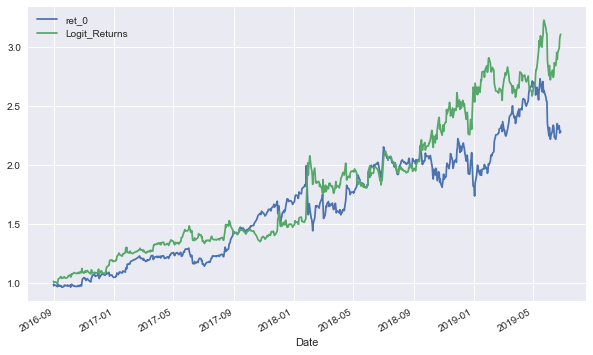

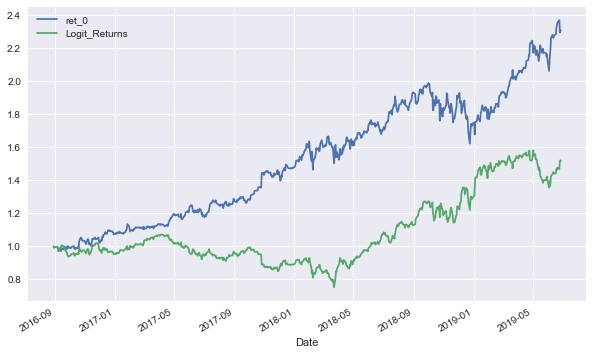

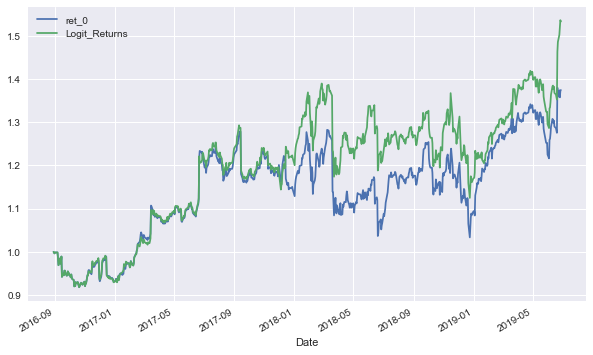

In [41]:
test_VMW[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));
test_MSFT[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));
test_ORCL[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [42]:
lm_VMW.predict_proba(train_VMW[cols])
lm_MSFT.predict_proba(train_MSFT[cols])
lm_ORCL.predict_proba(train_ORCL[cols])

array([[0.00386236, 0.01946985, 0.42724361, ..., 0.4635921 , 0.01392967,
        0.00479227],
       [0.00436562, 0.01772072, 0.41351721, ..., 0.46687642, 0.0189672 ,
        0.00538491],
       [0.00380144, 0.02127206, 0.42602475, ..., 0.45196073, 0.01467198,
        0.00330202],
       ...,
       [0.00343695, 0.01675934, 0.41795861, ..., 0.47265348, 0.0172301 ,
        0.00419698],
       [0.00491539, 0.02459497, 0.42899781, ..., 0.44677798, 0.01648094,
        0.00422248],
       [0.00359889, 0.02071685, 0.42119977, ..., 0.4639345 , 0.01771311,
        0.00352476]])

So based on our multinomial regression still catches the tendency of the asset prices. But we cannot easily conclude that this model is valid. We need more validation as we did before

In [43]:
###Now we get the number of splitting iterations in the cross-validator
kfold.get_n_splits(VMW_laggedReturns.iloc[:,2:7])

#We first cross-validate our VMW logit model
logit_VMW = linear_model.LogisticRegression(C=1e5,solver ='lbfgs',multi_class='multinomial',penalty='l2')
logit_VMW.fit(VMW_laggedReturns.iloc[:,2:7],VMW_laggedReturns.iloc[:,7])
crossval_VMW = cross_val_score(logit_VMW,VMW_laggedReturns.iloc[:,2:7],(VMW_laggedReturns.iloc[:,7]),cv=kfold,scoring = 'accuracy')
print("5-Fold Cross Validation Accuracy For VMW Logit Model: %.4f"%crossval_VMW.mean())

#We second cross-validate our MSFT logit model
logit_MSFT = linear_model.LogisticRegression(C=1e5,solver ='lbfgs',multi_class='multinomial',penalty='l2')
logit_MSFT.fit(MSFT_laggedReturns.iloc[:,2:7], MSFT_laggedReturns.iloc[:,7])
crossval_MSFT = cross_val_score(logit_MSFT,MSFT_laggedReturns.iloc[:,2:7],(MSFT_laggedReturns.iloc[:,7]),cv=kfold,scoring = 'accuracy')
print("5-Fold Cross Validation Accuracy For MSFT Logit Model: %.4f"%crossval_MSFT.mean())

#We second cross-validate our ORCL logit model
logit_ORCL = linear_model.LogisticRegression(C=1e5,solver ='lbfgs',multi_class='multinomial',penalty='l2')
logit_ORCL.fit(ORCL_laggedReturns.iloc[:,2:6], ORCL_laggedReturns.iloc[:,7])
crossval_ORCL = cross_val_score(logit_ORCL,ORCL_laggedReturns.iloc[:,2:7],(ORCL_laggedReturns.iloc[:,7]),cv=kfold,scoring = 'accuracy')
print("5-Fold Cross Validation Accuracy For MSFT Logit Model: %.4f"%crossval_ORCL.mean())

5-Fold Cross Validation Accuracy For VMW Logit Model: 0.4385
5-Fold Cross Validation Accuracy For MSFT Logit Model: 0.4549
5-Fold Cross Validation Accuracy For MSFT Logit Model: 0.4616


As we all can see in our new model, the Accuracy Score decrease than our previous model, but it does not mean our model perform worse than our old model, because when the number of class increases, the difficulty of ranking increases, too!

We still need to do further validation.

We need to notice 2 points of our multinomial regression model
1. AUC analysis does not support our model
2. Confusion Matrices under this model may be sparse, so validation becomes difficult

So we have to use some other method to validate our model:

1. Compute correlation between our predicted series with the real series
2. Compute the sum of square of difference between predicted series and real series

This two methods can better tell us whether our prediction tracks the real series. Here we use the first method for example

In [44]:
test_VMW['real_NAV'] = test_VMW['ret_0'].cumsum().apply(np.exp)
test_VMW['predicted_NAV'] = test_VMW['Logit_Returns'].cumsum().apply(np.exp)
np.corrcoef(test_VMW['real_NAV'],test_VMW['predicted_NAV'])

array([[1.        , 0.92649558],
       [0.92649558, 1.        ]])

In [45]:
test_MSFT['real_NAV'] = test_MSFT['ret_0'].cumsum().apply(np.exp)
test_MSFT['predicted_NAV'] = test_MSFT['Logit_Returns'].cumsum().apply(np.exp)
np.corrcoef(test_MSFT['real_NAV'],test_MSFT['predicted_NAV'])

array([[1.       , 0.7101876],
       [0.7101876, 1.       ]])

In [46]:
test_ORCL['real_NAV'] = test_ORCL['ret_0'].cumsum().apply(np.exp)
test_ORCL['predicted_NAV'] = test_ORCL['Logit_Returns'].cumsum().apply(np.exp)
np.corrcoef(test_ORCL['real_NAV'],test_ORCL['predicted_NAV'])

array([[1.        , 0.93648496],
       [0.93648496, 1.        ]])

You will amazingly find that when we use Multinomial Logit Regression, our prediction surprisingly catches the real series

#### 1.2.5 Extension II: Model with Additional Features

Now we almost finished our analysis on our models concentrating on lagged returns. Now we will start make our model little more complicated, we will add new features into our existing models! Let me first introduce new factors we will add:

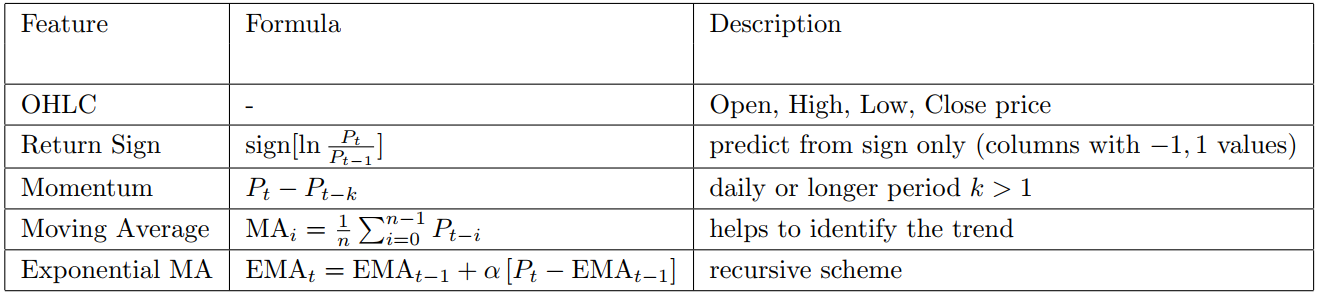

Now let us work on data processing!

##### 1.2.5.1 Feature Construction

In [47]:
###First define a function to compute z-score of a dataframe cols-by-cols
def get_ZScore(df):
    cols = list(df.columns)
    for col in cols:
        col_zscore = col + '_zscore'
        df[col_zscore] = (df[col] - df[      col].mean())/df[col].std(ddof=0)
    return df

In [48]:
### We need to redefine our getLaggedReturns function 
def getLaggedReturns(df,lags = 5, window_length = 1):
    #df: pandas Dataframe type variable, and column 'Close' should be included
    #lags: how many lagged returns do you want
    #window_length: the window length we use to compute each return
    df2 = pd.DataFrame(df)
    df2['ret_0'] = np.log(df2['Close']/df2['Close'].shift(window_length))
    
        
    for lag in range( 1,lags + 1 ):
        col = 'ret_%d'%lag
        df2[col] = df2['ret_0'].shift(lag)
    df2.dropna(inplace = True)
    
    return df2

Create matrix to store features (factors),outputs and predictions;

$\text{Factor 1: Store lagged returns as our first type of factors into our new matrix}$

In [49]:
VMW_factors = getLaggedReturns(VMW)
MSFT_factors = getLaggedReturns(MSFT)
ORCL_factors = getLaggedReturns(ORCL)

Classify price movement into 2 classes: 1 and 0

In [50]:
VMW_factors['Y'] = VMW_factors['ret_0']
VMW_factors['Y'][VMW_factors['Y']>0] = 1
VMW_factors['Y'][VMW_factors['Y']<=0] = 0

MSFT_factors['Y'] = MSFT_factors['ret_0']
MSFT_factors['Y'][MSFT_factors['Y']>0] = 1
MSFT_factors['Y'][MSFT_factors['Y']<=0] = 0

ORCL_factors['Y'] = ORCL_factors['ret_0']
ORCL_factors['Y'][ORCL_factors['Y']>0] = 1
ORCL_factors['Y'][ORCL_factors['Y']<=0] = 0

$\text{Factor 2: Return Sign}$

In [51]:
def SetReturnSign(df,cols):
    for idx,col in enumerate(cols):
        df['Sign'+str(idx)] = np.sign(df[col])

In [52]:
cols =['ret_0','ret_1','ret_2','ret_3','ret_4','ret_5']
SetReturnSign(VMW_factors,cols)
SetReturnSign(MSFT_factors,cols)
SetReturnSign(ORCL_factors,cols)

$\text{Factor 3: High Low Spread}$

Before we continue to work on our model, we need to shift 'High','Low','Open','Close' by one row, then each date's  'High','Low','Open','Close' and not matched date's  'High','Low','Open','Close', but the day before the matched date's

In [53]:
VMW_factors[['High','Low','Open','Close']]=VMW_factors[['High','Low','Open','Close']].shift(1)
VMW_factors = VMW_factors.dropna()

MSFT_factors[['High','Low','Open','Close']]=MSFT_factors[['High','Low','Open','Close']].shift(1)
MSFT_factors = MSFT_factors.dropna()

ORCL_factors[['High','Low','Open','Close']]=ORCL_factors[['High','Low','Open','Close']].shift(1)
ORCL_factors = ORCL_factors.dropna()
MSFT_factors.head(3)

High    Low       Open      Close      Volume  Adj Close  \
Date                                                                    
2010-01-13  30.40  29.91  30.150000  30.070000  51863500.0  24.049570   
2010-01-14  30.52  30.01  30.260000  30.350000  63228100.0  24.532942   
2010-01-15  31.10  30.26  30.309999  30.959999  79913200.0  24.453693   

               ret_0     ret_1     ret_2     ret_3     ret_4     ret_5    Y  \
Date                                                                          
2010-01-13  0.009269 -0.006629 -0.012802  0.006873 -0.010454 -0.006156  1.0   
2010-01-14  0.019899  0.009269 -0.006629 -0.012802  0.006873 -0.010454  1.0   
2010-01-15 -0.003235  0.019899  0.009269 -0.006629 -0.012802  0.006873  0.0   

            Sign0  Sign1  Sign2  Sign3  Sign4  Sign5  
Date                                                  
2010-01-13    1.0   -1.0   -1.0    1.0   -1.0   -1.0  
2010-01-14    1.0    1.0   -1.0   -1.0    1.0   -1.0  
2010-01-15   -1.0    1.0    1.0   -1.0   -1.0    1.0

In [54]:
def SetHighLowSpread(targetDF,sourceDF):
    targetDF['HLSpread'] = (sourceDF['High']-sourceDF['Low'])/sourceDF['Low']

In [55]:
SetHighLowSpread(VMW_factors,VMW_factors)
SetHighLowSpread(ORCL_factors,ORCL_factors)
SetHighLowSpread(MSFT_factors,MSFT_factors)

$\text{Factor 4: High Open Spread}$

In [56]:
def SetHighOpenSpread(targetDF,sourceDF):
    targetDF['HOSpread'] = (sourceDF['High']-sourceDF['Open'])/sourceDF['Open']

In [57]:
SetHighOpenSpread(VMW_factors,VMW_factors)
SetHighOpenSpread(ORCL_factors,ORCL_factors)
SetHighOpenSpread(MSFT_factors,MSFT_factors)

$\text{Factor 5: Open Low Spread}$

In [58]:
def SetOpenLowSpread(targetDF,sourceDF):
    targetDF['OLSpread'] = (sourceDF['Open']-sourceDF['Low'])/sourceDF['Open']

In [59]:
SetOpenLowSpread(VMW_factors,VMW_factors)
SetOpenLowSpread(ORCL_factors,ORCL_factors)
SetOpenLowSpread(MSFT_factors,MSFT_factors)

$\text{Factor 6: Momentums: 11 days, 22 days, 66 days, 125 days}$

In [60]:
def SetMomentum(targetDF,sourceDF,window_lengths=[11,22,66,125]):
    for window_length in window_lengths:
        momentum = (sourceDF.shift(window_length)['Close']-sourceDF['Close'])/sourceDF['Close']
        targetDF = pd.DataFrame(targetDF.iloc[window_length:,:])
        targetDF['MOM'+str(window_length)]=momentum
    
    targetDF = targetDF.dropna()
    return targetDF

In [61]:
VMW_factors=SetMomentum(VMW_factors,VMW_factors)
VMW_factors=SetMomentum(VMW_factors,VMW_factors)
VMW_factors=SetMomentum(VMW_factors,VMW_factors)
VMW_factors=SetMomentum(VMW_factors,VMW_factors)

MSFT_factors=SetMomentum(MSFT_factors,MSFT_factors)
MSFT_factors=SetMomentum(MSFT_factors,MSFT_factors)
MSFT_factors=SetMomentum(MSFT_factors,MSFT_factors)
MSFT_factors=SetMomentum(MSFT_factors,MSFT_factors)

ORCL_factors=SetMomentum(ORCL_factors,ORCL_factors)
ORCL_factors=SetMomentum(ORCL_factors,ORCL_factors)
ORCL_factors=SetMomentum(ORCL_factors,ORCL_factors)
ORCL_factors=SetMomentum(ORCL_factors,ORCL_factors)

##### 1.2.5.2 Model Construction

$\text{1. Split Dataset into training set and testing set}$

In [62]:
num_training = int(0.7*VMW_factors.shape[0])

train_VMW = VMW_factors.iloc[0:num_training,:]
train_MSFT = MSFT_factors.iloc[0:num_training,:]
train_ORCL = ORCL_factors.iloc[0:num_training,:]

test_VMW = VMW_factors.iloc[num_training:,:]
test_MSFT = MSFT_factors.iloc[num_training:,:]
test_ORCL = ORCL_factors.iloc[num_training:,:]

In [63]:
cols = list(VMW_factors.columns)
cols = cols[14:]

$\text{2. Model Validation}$

$\text{1. Validation on VMW}$

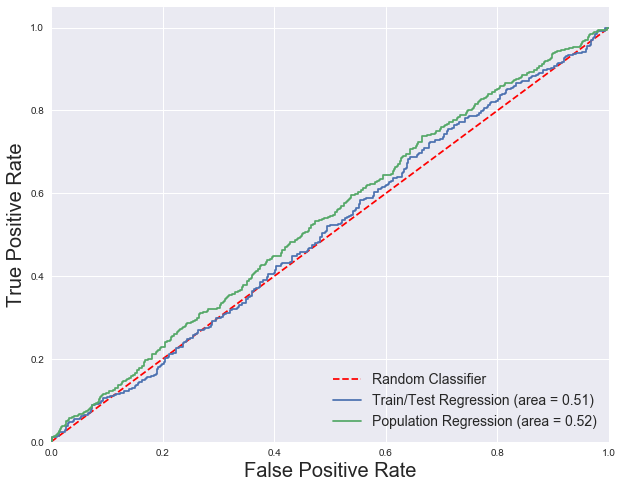

In [64]:
#plot_logit_ROC(default_ind,Y_test,X_test,logit,Y_response,X_features)
X_Train_VMW, X_Test_VMW, Y_Train_VMW, Y_Test_VMW = model_selection.train_test_split(VMW_factors[cols],
                                                                                    VMW_factors['Y'] ,
                                                                                    test_size=0.6, shuffle=True)
logit_VMW = linear_model.LogisticRegression(C = 1e15,solver ='lbfgs',penalty = 'l2')
logit_VMW.fit(X_Train_VMW,Y_Train_VMW)
plot_logit_ROC(1,Y_Test_VMW,X_Test_VMW,logit_VMW,VMW_factors['Y'],VMW_factors[cols])

In [65]:
Y_VMW_pred = logit_VMW.predict(X_Test_VMW)
confusion_matrix_VMW = confusion_matrix(Y_Test_VMW,Y_VMW_pred)
print("Confusion Matrix")
print(confusion_matrix_VMW)

Confusion Matrix
[[151 255]
 [170 315]]


$\text{Validation on MSFT}$

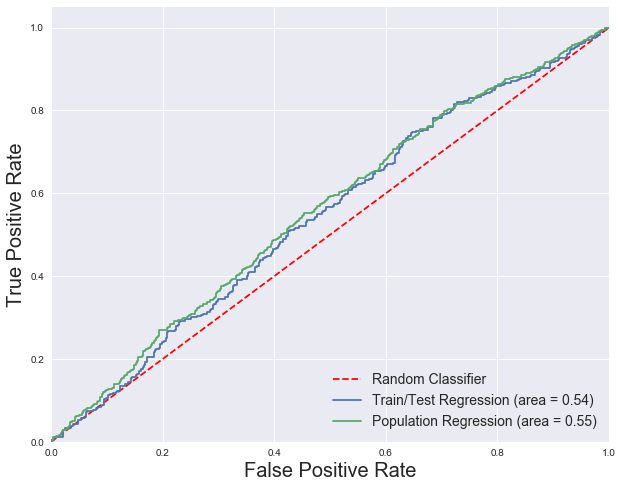

In [66]:
#plot_logit_ROC(default_ind,Y_test,X_test,logit,Y_response,X_features)
X_Train_MSFT, X_Test_MSFT, Y_Train_MSFT, Y_Test_MSFT = model_selection.train_test_split(MSFT_factors[cols],
                                                                                    MSFT_factors['Y'] ,
                                                                                    test_size=0.6, shuffle=True)
logit_MSFT = linear_model.LogisticRegression(C = 1e15,solver ='lbfgs',penalty = 'l2')
logit_MSFT.fit(X_Train_MSFT,Y_Train_MSFT)
plot_logit_ROC(1,Y_Test_MSFT,X_Test_MSFT,logit_MSFT,MSFT_factors['Y'],MSFT_factors[cols])

In [67]:
Y_MSFT_pred = logit_MSFT.predict(X_Test_MSFT)
confusion_matrix_MSFT = confusion_matrix(Y_Test_MSFT,Y_MSFT_pred)
print("Confusion Matrix")
print(confusion_matrix_MSFT)

Confusion Matrix
[[140 274]
 [119 358]]


$\text{Validation on ORCL}$

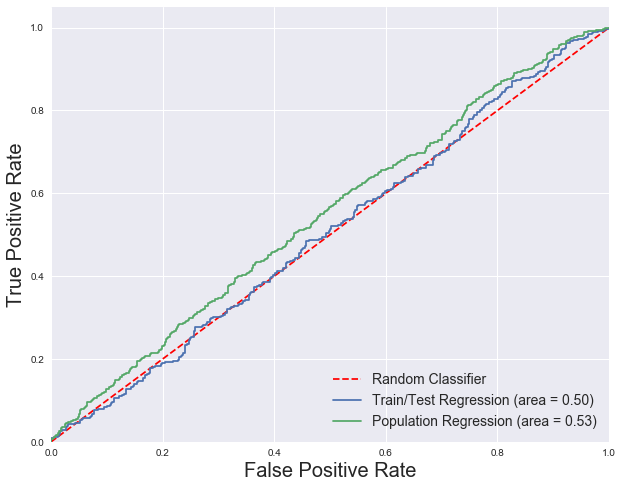

In [68]:
#plot_logit_ROC(default_ind,Y_test,X_test,logit,Y_response,X_features)
X_Train_ORCL, X_Test_ORCL, Y_Train_ORCL, Y_Test_ORCL = model_selection.train_test_split(ORCL_factors[cols],
                                                                                    ORCL_factors['Y'] ,
                                                                                    test_size=0.6, shuffle=True)
logit_ORCL = linear_model.LogisticRegression(C = 1e15,solver ='lbfgs',penalty = 'l2')
logit_ORCL.fit(X_Train_ORCL,Y_Train_ORCL)
plot_logit_ROC(1,Y_Test_ORCL,X_Test_ORCL,logit_ORCL,ORCL_factors['Y'],ORCL_factors[cols])

In [69]:
Y_ORCL_pred = logit_ORCL.predict(X_Test_ORCL)
confusion_matrix_ORCL = confusion_matrix(Y_Test_ORCL,Y_ORCL_pred)
print("Confusion Matrix")
print(confusion_matrix_ORCL)

Confusion Matrix
[[195 223]
 [219 254]]


So, finally as we add more factors, our model becomes robust, the high AUC and clear confusion matrix means that our model now is not a weak one

$\text{1.2.5.3 Simple Coefficient Analysis}$

In [70]:
print('Coefficient for Logit Regression on VMW : ')
print(logit_VMW.coef_.ravel())
print('Coefficient for Logit Regression on MSFT : ')
print(logit_MSFT.coef_.ravel())
print('Coefficient for Logit Regression on ORCL : ')
print(logit_ORCL.coef_.ravel())

Coefficient for Logit Regression on VMW : 
[ 0.08917412 -0.06630479  0.01667561  0.10336928  0.06653401 -2.99227702
 -7.17597181  4.40543198  2.38090908  0.1758564  -2.57966224  0.93066745]
Coefficient for Logit Regression on MSFT : 
[ 2.70608986e-03  1.68811181e-02  7.67408204e-02  1.16757217e-01
  6.48636703e-02 -7.90072360e+00 -7.79872380e+00 -1.11753865e-02
  4.70757078e-02  2.42256892e+00  2.47150691e+00 -1.66086551e+00]
Coefficient for Logit Regression on ORCL : 
[-2.53390492e-01 -7.92479777e-03  1.57003277e-01 -4.65338127e-02
 -8.44980485e-03 -7.32164492e+00  2.75056582e+00 -9.43599967e+00
  1.26095740e+00  3.02760216e-01  5.07912378e+00 -1.96154735e+00]


In [71]:
VMW_coef = pd.Series(logit_VMW.coef_.ravel(),index = cols)
MSFT_coef = pd.Series(logit_MSFT.coef_.ravel(),index = cols)
ORCL_coef = pd.Series(logit_ORCL.coef_.ravel(),index = cols)

In [72]:
print("VMW Regression Model Coefficient Analysis")
VMW_coef.sort_values()

VMW Regression Model Coefficient Analysis


HOSpread   -7.175972
HLSpread   -2.992277
MOM66      -2.579662
Sign2      -0.066305
Sign3       0.016676
Sign5       0.066534
Sign1       0.089174
Sign4       0.103369
MOM22       0.175856
MOM125      0.930667
MOM11       2.380909
OLSpread    4.405432
dtype: float64

In [73]:
print("MSFT Regression Model Coefficient Analysis")
MSFT_coef.sort_values()

MSFT Regression Model Coefficient Analysis


HLSpread   -7.900724
HOSpread   -7.798724
MOM125     -1.660866
OLSpread   -0.011175
Sign1       0.002706
Sign2       0.016881
MOM11       0.047076
Sign5       0.064864
Sign3       0.076741
Sign4       0.116757
MOM22       2.422569
MOM66       2.471507
dtype: float64

In [74]:
print("ORCL Regression Model Coefficient Analysis")
ORCL_coef.sort_values()

ORCL Regression Model Coefficient Analysis


OLSpread   -9.436000
HLSpread   -7.321645
MOM125     -1.961547
Sign1      -0.253390
Sign4      -0.046534
Sign5      -0.008450
Sign2      -0.007925
Sign3       0.157003
MOM22       0.302760
MOM11       1.260957
HOSpread    2.750566
MOM66       5.079124
dtype: float64

We need to note that we cannot easily compare the factors' strength in our models just based on the measure of our coefficients, because here we did not compute Z-Scores for each factor! In practice, we indeed need to do something like Z-Scoring.

But we still can get some important conclusions:

1. There are no consistent features among stocks which can help us predict the price movement

2. Adding more features indeed help us make model a little more robust, but it is still a black box problem, we cannot easily conclude that our model can help us make profit


#### 1.3 Naive Baysian Classifier

##### 1.3.1 Generative Learning Algorithm and Discriminative Learning Algorithm

Now we will introduce a new classifier to predict our stock price movement, it is called $\text{Naive Baysian Classifier}$. This algorithm is relatively broad, and it includes many sub-algorithms, I think scikit-learn official websites can give us a very good category: 
1. Gaussian Naive Bayes
2. Multinomial Naive Bayes
3. Complement Naive Bayes
4. Bernoulli Naive Bayes

Before we start talking about these algorithms, it is better to have an overview first. Compared to $\text{Logistic Regression}$, which is a kind of $\text{Discriminative Learning Algorithm}$, $\text{Bayesian Classifier}$ is a kind of $\text{Generative Learning Algorithm}$.

Briefly, if you want to label output directly using input, we say that you are using Discriminative Learning Algorithm. Using logistic regression as an example, we usually predict the output probability distribution directly as follows:

$$p(y|x;\theta)= h_{\theta}(x)^{y}(1-h_{\theta}(x))^{y}$$

we can easily find that there is no explicit assumption on x's distribution, and we input x and then directly get our target probability distribution of y conditional on x.

Different from the Discriminative Learning Algorithm, Generative Learning Algorithm requires us to model the conditional probability of x conditional on y, and then we pick the nearest y to our sample, mathematically, it can be expressed as:

we first compute  

$$p(x|y), p(y), and\  p(x)$$

then we get

$$p(y|x)= \frac{p(x|y)p(y)}{p(x)}$$

For better explaining how our model is going, we will concentrate on three most frequently used Naive Bayes:Gaussian,Bernoulli


##### 1.3.2 Gaussian Naive Bayes Classifier

$\text{I. Derivation}$

Gaussian Naive Bayes Classifier is a generative classifier which models $p(x|y)$ and limits :

$$x|y=0 \sim N(\mu_0,\Sigma)$$ 

$$x|y=1 \sim N(\mu_1,\Sigma)$$ 

$$y \sim Bernoulli(\phi)$$

Explicitly:

$$p(y) = \phi^y(1-\phi)^{1-y}$$

$$p(x|y=0) = \frac{1}{(2\pi)^{d/2}|{\Sigma}|^{1/2}}exp(-\frac{1}{2}(x-\mu_0)^T\Sigma^{-1}(x-\mu_0))$$

$$p(x|y=1) = \frac{1}{(2\pi)^{d/2}|{\Sigma}|^{1/2}}exp(-\frac{1}{2}(x-\mu_1)^T\Sigma^{-1}(x-\mu_1))$$

Note that here we implictly assume that there is only one covariance matrix $\Sigma$

we need to notice that 
$$p(y|x)= \frac{p(x|y)p(y)}{p(x)}$$

where $p(x)$ is a known unconditional distribution, which is a constant, so if we want to maximize the likelihood function of $p(y|x)$, we can just maximize $p(x|y)p(y) = p(x,y)$

Then we can get the log-likelihood of joint distribution of x and y :

$$l(\phi,\mu_0,\mu_1,\Sigma)=log\prod^n_{i=1}p(x^{(i)},y^{(i)};\phi,\mu_0,\mu_1,\Sigma)$$

$$=log\prod^{n}_{i=1}p(x^{(i)}|y^{(i)};\mu_0,\mu_1,\Sigma)p(y^{(i)};\phi)$$

Then we can get:

$$\phi = \frac{1}{n}\sum^{n}_{i=1}1\{y^{(i)}=1\}$$

$$\mu_0 = \frac{\sum^n_{i=1}1\{y^{(i)}=0\}x^{(i)}}{\sum_{i=1}^n1\{y^{(i)}=0\}}$$

$$\mu_1 =\frac{\sum^n_{i=1}1\{y^{(i)}=1\}x^{(i)}}{\sum_{i=1}^n1\{y^{(i)}=1\}}$$

$$\Sigma =\frac{1}{n} \sum^{n}_{i=1}(x^{(i)}-\mu_{y^{(i)}})(x^{(i)}-\mu_{y^{(i)}})^T$$


$\text{II.Feature Construction}$

Now we want to link this to our prediction model. What we should do first is to set features under the model limitations. In Gaussian Bayes, 

1. we need to first set our output to be a Bernoulli Distribution: so we make the return >0 to be 1 and return < 0 to be -1

2. We need to make sure that the 

$$x|y=0 \sim N(\mu_0,\Sigma)$$ 

$$x|y=1 \sim N(\mu_1,\Sigma)$$ 

So we need to first test the normality of our features. But here is some difficulties that we cannot get strong tools supporting multivariate normal distribution test and coding a function by ourselves may be very time-consuming, so what we can do is only to assume that there are no correlation between each features and they follow a normal distribution. Please this is only an assumption which may influence the accuracy of our model, but we do not have better solution, right? I will try to code it in C++ in my spare time and share it with you but right now for this project, I would like not to do it.

Let test each feature's normality, and if the original feature is not normal distributed, we can convert it into normal distribution or abandom using it :
1. Normality Test of Momentum
2. Normality Test of Lagged Return
3. Normality Test of OHLC

Actually, we know the financial data has strong fat-tails, so it is really very $\text{difficult}$ to make our data be really normal distribution. For example, our data cannot pass Chi-Square test, and qq-plots are also ugly, so we can only do some rough job on this:
using histogram to check whether our data is like Normal Distribution 

In [75]:
###test on Momentum
from scipy import stats
import statsmodels.api as sm
print(stats.normaltest(VMW_factors['MOM11']))
print(stats.normaltest(MSFT_factors['MOM11']))
print(stats.normaltest(ORCL_factors['ret_1']))

NormaltestResult(statistic=431.55920976236035, pvalue=1.941369904580812e-94)
NormaltestResult(statistic=87.52620176783893, pvalue=9.861132065423967e-20)
NormaltestResult(statistic=267.7180885958406, pvalue=7.341008189622492e-59)


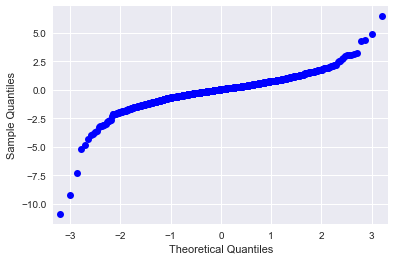

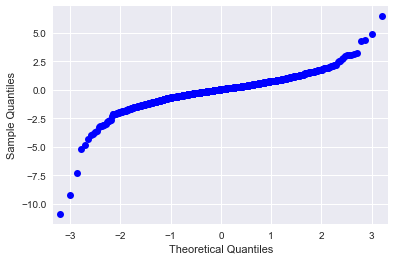

In [76]:
sm.qqplot(VMW_factors['ret_0'],fit= True)

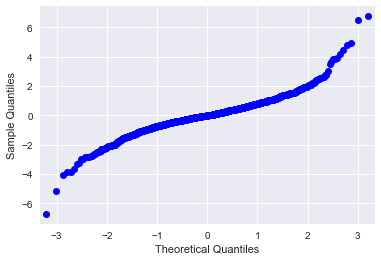

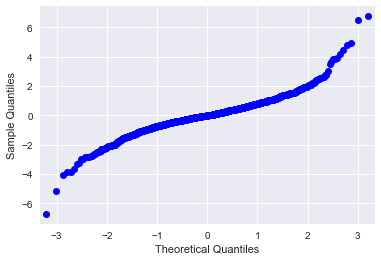

In [77]:
sm.qqplot(MSFT_factors['ret_0'],fit= True)

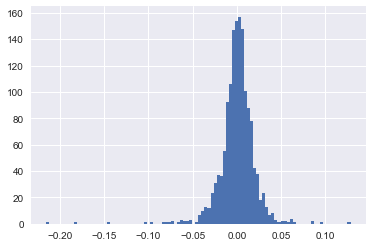

In [78]:
VMW_factors['ret_1'].hist(bins=100)

When we directly use High Low Spread, we find it is not like normal distribution at all

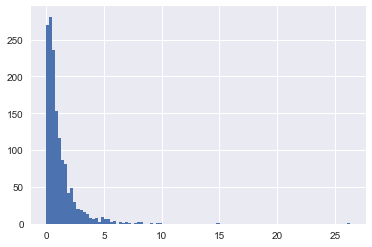

In [79]:
pd.Series(VMW_factors['High']-VMW_factors['Close']).hist(bins = 100)

So maybe when we log it, we can get something normal

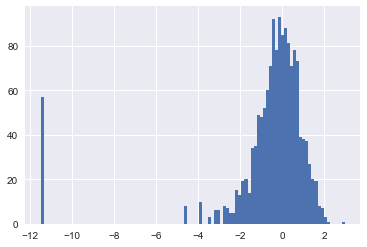

In [80]:
#Log our High Low Spread we can get a histogram like normal distribution
pd.Series(np.log(VMW_factors['High']-VMW_factors['Open']+1e-5)).hist(bins = 100)

Now it become more qualified but we still need to drop the extreme values 

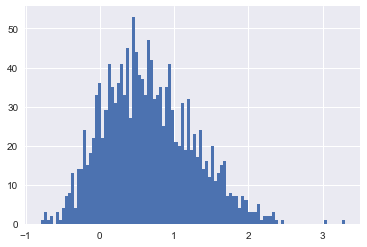

In [81]:
#Log our High Low Spread we can get a histogram like normal distribution
pd.Series(np.log(VMW_factors['High']-VMW_factors['Low'])).hist(bins = 100)

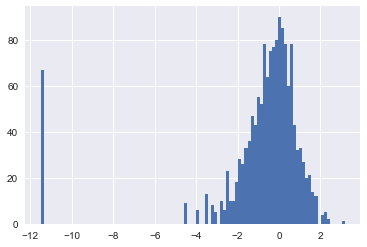

In [82]:
pd.Series(np.log(VMW_factors['Open']-VMW_factors['Low']+1e-5)).hist(bins = 100)

I think we it is enough for us to start to work on our real DataFrame

In [83]:
###First we need to construct dataframes
VMW_factors['GDA_HLSpread'] = np.log(VMW_factors['High']-VMW_factors['Low'])
VMW_factors['GDA_HOSpread'] = np.log(VMW_factors['High']-VMW_factors['Open'])
VMW_factors['GDA_HCSpread'] = np.log(VMW_factors['High']-VMW_factors['Close'])

MSFT_factors['GDA_HLSpread'] = np.log(MSFT_factors['High']-MSFT_factors['Low'])
MSFT_factors['GDA_HOSpread'] = np.log(MSFT_factors['High']-MSFT_factors['Open'])
MSFT_factors['GDA_HCSpread'] = np.log(MSFT_factors['High']-MSFT_factors['Close'])

ORCL_factors['GDA_HLSpread'] = np.log(ORCL_factors['High']-ORCL_factors['Low'])
ORCL_factors['GDA_HOSpread'] = np.log(ORCL_factors['High']-ORCL_factors['Open'])
ORCL_factors['GDA_HCSpread'] = np.log(ORCL_factors['High']-ORCL_factors['Close'])

In [84]:
ORCL_factors.head(3)

High        Low   Open      Close      Volume  Adj Close  \
Date                                                                        
2013-08-06  32.900002  32.549999  32.59  32.779999  18620900.0  30.301161   
2013-08-07  33.220001  32.700001  32.75  33.000000  17416900.0  30.135887   
2013-08-08  33.000000  32.680000  32.77  32.820000  14204600.0  30.319538   

               ret_0     ret_1     ret_2     ret_3      ...       HLSpread  \
Date                                                    ...                  
2013-08-06  0.006689  0.006427 -0.005511  0.012289      ...       0.010753   
2013-08-07 -0.005469  0.006689  0.006427 -0.005511      ...       0.015902   
2013-08-08  0.006075 -0.005469  0.006689  0.006427      ...       0.009792   

            HOSpread  OLSpread     MOM11     MOM22     MOM66    MOM125  \
Date                                                                     
2013-08-06  0.009512  0.001227 -0.028066 -0.063453  0.011592  0.082367   
2013-08-07  0.014351  0.001527 -0.034242 -0.054848  0.020909  0.063636   
2013-08-08  0.007019  0.002746 -0.022852 -0.035649  0.017063  0.053017   

            GDA_HLSpread  GDA_HOSpread  GDA_HCSpread  
Date                                                  
2013-08-06     -1.049816     -1.171179     -2.120241  
2013-08-07     -0.653926     -0.755020     -1.514122  
2013-08-08     -1.139435     -1.469678     -1.714797  

[3 rows x 29 columns]

In [85]:
cols = ['ret_1','ret_2','ret_3','ret_4','ret_5','GDA_HCSpread','GDA_HOSpread','GDA_HLSpread','MOM11','MOM22','MOM66','MOM125']

In [86]:
###Clean Invalid Data
VMW_factors = VMW_factors.replace([np.inf, -np.inf], np.nan).dropna()
MSFT_factors = MSFT_factors.replace([np.inf, -np.inf], np.nan).dropna()
ORCL_factors = ORCL_factors.replace([np.inf, -np.inf], np.nan).dropna()

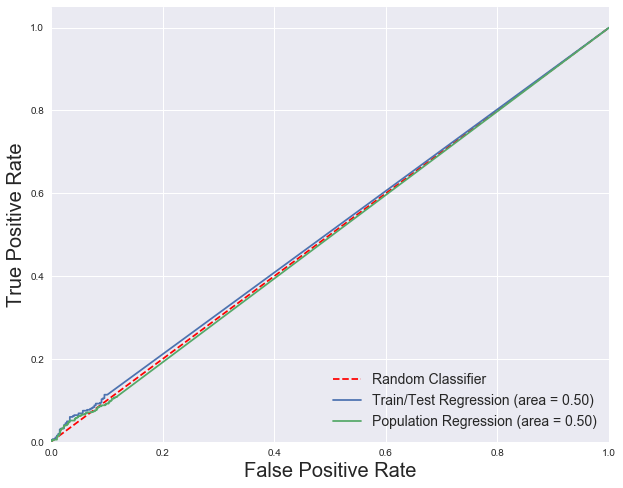

In [87]:
###Now We can work on Naive Bayes
from sklearn.naive_bayes import GaussianNB

X_Train_MSFT, X_Test_MSFT, Y_Train_MSFT, Y_Test_MSFT = model_selection.train_test_split(MSFT_factors[cols],
                                                                                    MSFT_factors['Y'] ,
                                                                                    test_size=0.6, shuffle=True)
gaussianBayes_MSFT = GaussianNB()
gaussianBayes_MSFT.fit(X_Train_VMW,Y_Train_VMW)
plot_logit_ROC(1,Y_Test_MSFT,X_Test_MSFT,gaussianBayes_MSFT,MSFT_factors['Y'],MSFT_factors[cols])

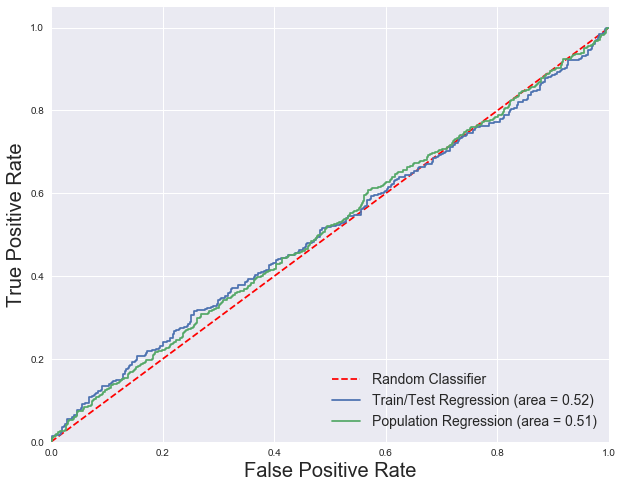

In [88]:
from sklearn.naive_bayes import GaussianNB

X_Train_VMW, X_Test_VMW, Y_Train_VMW, Y_Test_VMW = model_selection.train_test_split(VMW_factors[cols],
                                                                                    VMW_factors['Y'] ,
                                                                                    test_size=0.6, shuffle=True)
gaussianBayes_VMW = GaussianNB()
gaussianBayes_VMW.fit(X_Train_MSFT,Y_Train_MSFT)
plot_logit_ROC(1,Y_Test_VMW,X_Test_VMW,gaussianBayes_VMW,VMW_factors['Y'],VMW_factors[cols])

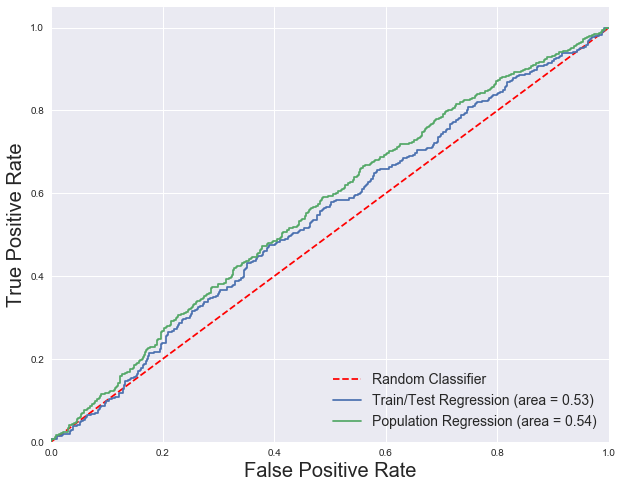

In [89]:
from sklearn.naive_bayes import GaussianNB

X_Train_ORCL, X_Test_ORCL, Y_Train_ORCL, Y_Test_ORCL = model_selection.train_test_split(ORCL_factors[cols],
                                                                                    ORCL_factors['Y'] ,
                                                                                    test_size=0.7, shuffle=True)
gaussianBayes_ORCL = GaussianNB()
gaussianBayes_ORCL.fit(X_Train_ORCL,Y_Train_ORCL)
plot_logit_ROC(1,Y_Test_ORCL,X_Test_ORCL,gaussianBayes_ORCL,ORCL_factors['Y'],ORCL_factors[cols])

So based on our Gaussian Naive Bayes, our models are still not valid and near to the Random Classifier. Now let us turn to a new type of Bayesian Classifier:Bernoulli Naive Bayes

##### 1.3..3 Bernoulli Naive Bayes Classifier

$\text{I. Derivation}$

Suppose we have a feature vector with k-dimension as follow:

$$x = \begin{bmatrix} x_1 \\ x_2 \\ . \\. \\ . \\ x_k \end{bmatrix}$$

This vector's element can only have two value, 1 or 0.

As we did in other generative algorithm, we should model :
$$p(x|y)$$

We need a strong but very useful assumption that:

$${x_i'\text{s  are conditionally independent given y}}$$

which means 

$$p(x_i|y,x_j) = p(x_j|y)$$

So we can have:

$$P(x_1,...,x_n | y)$$

$$=p(x_1|y)p(x_2|y,x_1)p(x_3|x_1,x_2)...p(x_n|y,x_1,...,x_{n-1})$$

$$=p(x_1|y)...p(x_n|y)$$

$$=\prod^{j=1}_{n}p(x_j|y)$$

Let us turn back to model $p(x|y)$

As we did before, 

$$p(x|y) = \frac{p(y|x)p(x)}{p(y)}$$

where $p(y)$ is know so we can regard it as constant, so if we want to maximize the likelihood function of $p(x|y)$, we only need to maximize the log-likelihood function of $p(y|x)p(x) = p(x,y)$. So now our problem is just to finding the parameters of our model, they are

$$p(x_j = 1 | y =1 )$$

$$p(x_j = 0 | y = 1)$$


$$p(x_j = 1 | y =0 )$$

$$p(x_j = 0 | y = 0)$$

$$p(y)$$

Because $$p(x_j = 1 | y =1 ) + p(x_j = 0 | y = 1) =0 $$

So we only need to make $\phi_{j|y=1} = p(x_j = 1| y = 1)$ ,$\phi_{j|y = 0}  = p (x_j = 1 | y = 0) $ , $\phi_y = p(y = 1)$ 

and then 

$$ p(x_j = 0| y = 1) = 1- \phi_{j|y=1} $$ and   $$p (x_j = 0 | y = 0) = 1- \phi_{j|y = 0} $$

So we can only parameterize our model using three parameters:

$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \phi_{j|y=1}$, $\phi_{j|y=0}$, $\phi_y$

Now we can compute the joint likelihood of data is :
$$L(\phi_y,\phi_{j|y=0},\phi_{j|y=1})=\prod^{n}_{i=1}p(x^{(i)},y^{(i)})$$

Maximize it with respect to $\phi_y$, $\phi_{j|y=0}$ and $\phi_{j|y=1}$, then we get:

$$\phi_{j|y=1} = \frac{\sum^{n}_{i=1}1\{x_{j}^{(i)}=1\wedge y^{(i)}=1\}}{\sum^{n}_{i=1}1\{y^{(i)}=1\}}$$

$$\phi_{j|y=1} = \frac{\sum^{n}_{i=0}1\{x_{j}^{(i)}=0\wedge y^{(i)}=1\}}{\sum^{n}_{i=1}1\{y^{(i)}=0\}}$$

$$\phi_y = \frac{1\{y^{(i)}=1\}}{n}$$

Now let us start coding!

We first need to determine how our features are

$\text{II. Features Construction}$

In Bernoulli Naive Bayes, all the features should be binary, so here we define our rule to convert real number to binary:

1. Return > 0 $\to$ 1 , Return $\leq$ 0 $\to$ 0
2. Spread > 0 $\to$ 1,  Return $\leq$ 0 $\to$ 0
3. Momentum > 0 $\to$ 1,  Momentum $\leq$ 0 $\to$ 0

Let us code

In [90]:
#Convert features to binary
def toBinaryFeature(df,cols):
    for col in cols:
        df[col][df[col]>0] = 1
        df[col][df[col]<=0] = 0

In [91]:
#Convert now
toBinaryFeature(VMW_factors,cols)
toBinaryFeature(MSFT_factors,cols)
toBinaryFeature(MSFT_factors,cols)

$\text{Bernoulli Bayes: VMW}$

In [92]:
from sklearn.naive_bayes import BernoulliNB

naivebayes_VMW = BernoulliNB()
naivebayes_VMW.fit(VMW_factors[cols],VMW_factors['Y'])
naivebayes_VMW.predict_proba(VMW_factors[cols])

array([[0.48924079, 0.51075921],
       [0.46320999, 0.53679001],
       [0.45135218, 0.54864782],
       ...,
       [0.49552703, 0.50447297],
       [0.38042437, 0.61957563],
       [0.49957207, 0.50042793]])

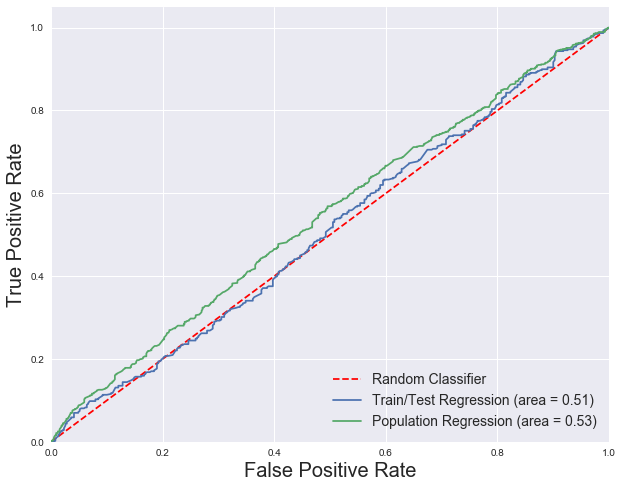

In [93]:
X_Train_VMW, X_Test_VMW, Y_Train_VMW, Y_Test_VMW = model_selection.train_test_split(VMW_factors[cols],
                                                                                    VMW_factors['Y'] ,
                                                                                    test_size=0.6, shuffle=True)
naivebayes_VMW.fit(X_Train_VMW,Y_Train_VMW)
plot_logit_ROC(1,Y_Test_VMW,X_Test_VMW,naivebayes_VMW,VMW_factors['Y'],VMW_factors[cols])

$\text{Bernoulli Bayes: MSFT}$ 

[[0.44251416 0.55748584]
 [0.34363794 0.65636206]
 [0.46408044 0.53591956]
 ...
 [0.54683996 0.45316004]
 [0.35130199 0.64869801]
 [0.45473004 0.54526996]]


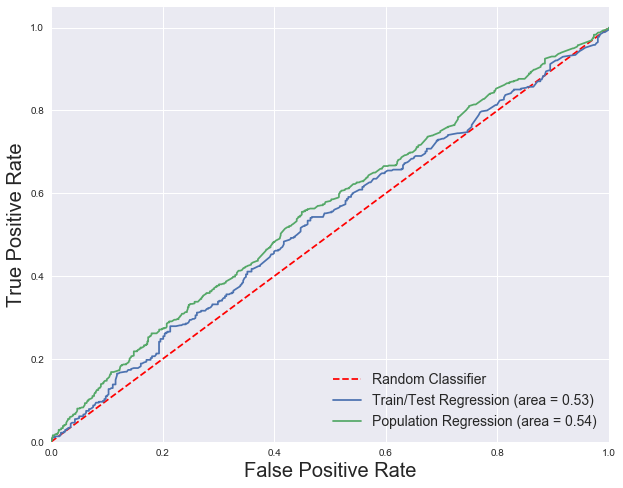

In [94]:
naivebayes_MSFT = BernoulliNB()
naivebayes_MSFT.fit(MSFT_factors[cols],MSFT_factors['Y'])
print(naivebayes_MSFT.predict_proba(MSFT_factors[cols]))

X_Train_MSFT, X_Test_MSFT, Y_Train_MSFT, Y_Test_MSFT = model_selection.train_test_split(MSFT_factors[cols],
                                                                                    MSFT_factors['Y'] ,
                                                                                    test_size=0.6, shuffle=True)
naivebayes_MSFT.fit(X_Train_MSFT,Y_Train_MSFT)
plot_logit_ROC(1,Y_Test_MSFT,X_Test_MSFT,naivebayes_MSFT,MSFT_factors['Y'],MSFT_factors[cols])

$\text{Bernoulli Bayes:ORCL}$

[[0.50288053 0.49711947]
 [0.51627935 0.48372065]
 [0.45656213 0.54343787]
 ...
 [0.43981168 0.56018832]
 [0.35492666 0.64507334]
 [0.56649443 0.43350557]]


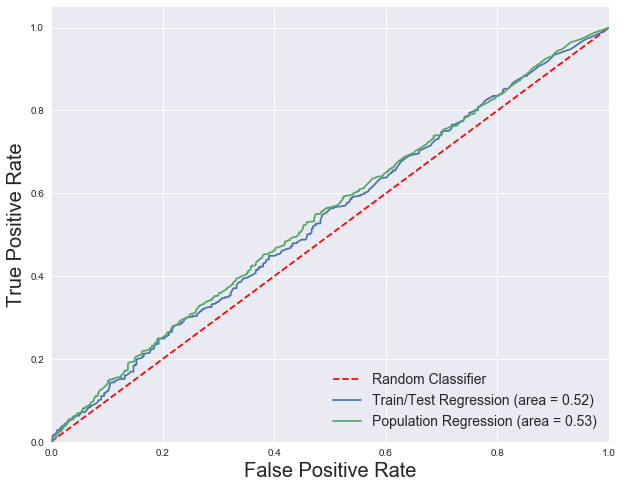

In [95]:
naivebayes_ORCL = BernoulliNB()
naivebayes_ORCL.fit(ORCL_factors[cols],ORCL_factors['Y'])
print(naivebayes_ORCL.predict_proba(ORCL_factors[cols]))

X_Train_ORCL, X_Test_ORCL, Y_Train_ORCL, Y_Test_ORCL = model_selection.train_test_split(ORCL_factors[cols],
                                                                                    ORCL_factors['Y'] ,
                                                                                    test_size=0.6, shuffle=True)
naivebayes_MSFT.fit(X_Train_ORCL,Y_Train_ORCL)
plot_logit_ROC(1,Y_Test_ORCL,X_Test_ORCL,naivebayes_ORCL,ORCL_factors['Y'],ORCL_factors[cols])

So based on our model we did before, we still cannot get a robust result. All the AUC curves are near to the random model.

#### 1.4 Support Vector Machine


##### 1.4.1 Introduction to Support Vector Machine
SVM can be a very great model to process regression, classification and outlier detection problem. But SVM is relatively abstract, and its mathematical derivation can be a very long story, so I will not talk too much on mathematics this time but talk more intuitive things. If you are interested in relevant mathematical stories, I will attach some necessary part in the appdendices.


Easily speaking, what the SVM do is seperating data by a decision boundary directly, which is very unlike what the Logit Regression Model, which needs a sigmoid to convert result to be a probability first, does.


In [96]:
#We first need to clean data as we did before.
cols =['ret_0','ret_1','ret_2','ret_3','ret_4','ret_5']
VMW = pd.DataFrame(web.DataReader('VMW',data_source = 'yahoo'))
MSFT = pd.DataFrame(web.DataReader('MSFT',data_source ='yahoo'))
ORCL = pd.DataFrame(web.DataReader('ORCL',data_source = 'yahoo'))
VMW_factors = getLaggedReturns(VMW)
MSFT_factors = getLaggedReturns(MSFT)
ORCL_factors = getLaggedReturns(ORCL)

VMW_factors['Y'] = VMW_factors['ret_0']
VMW_factors['Y'][VMW_factors['Y']>0] = 1
VMW_factors['Y'][VMW_factors['Y']<=0] = 0

MSFT_factors['Y'] = MSFT_factors['ret_0']
MSFT_factors['Y'][MSFT_factors['Y']>0] = 1
MSFT_factors['Y'][MSFT_factors['Y']<=0] = 0

ORCL_factors['Y'] = ORCL_factors['ret_0']
ORCL_factors['Y'][ORCL_factors['Y']>0] = 1
ORCL_factors['Y'][ORCL_factors['Y']<=0] = 0

SetReturnSign(VMW_factors,cols)
SetReturnSign(MSFT_factors,cols)
SetReturnSign(ORCL_factors,cols)

VMW_factors[['High','Low','Open','Close']]=VMW_factors[['High','Low','Open','Close']].shift(1)
VMW_factors = VMW_factors.dropna()


MSFT_factors[['High','Low','Open','Close']]=MSFT_factors[['High','Low','Open','Close']].shift(1)
MSFT_factors = MSFT_factors.dropna()

ORCL_factors[['High','Low','Open','Close']]=ORCL_factors[['High','Low','Open','Close']].shift(1)
ORCL_factors = ORCL_factors.dropna()

SetHighLowSpread(VMW_factors,VMW_factors)
SetHighLowSpread(ORCL_factors,ORCL_factors)
SetHighLowSpread(MSFT_factors,MSFT_factors)

SetHighOpenSpread(VMW_factors,VMW_factors)
SetHighOpenSpread(ORCL_factors,ORCL_factors)
SetHighOpenSpread(MSFT_factors,MSFT_factors)

SetOpenLowSpread(VMW_factors,VMW_factors)
SetOpenLowSpread(ORCL_factors,ORCL_factors)
SetOpenLowSpread(MSFT_factors,MSFT_factors)

VMW_factors=SetMomentum(VMW_factors,VMW_factors)
VMW_factors=SetMomentum(VMW_factors,VMW_factors)
VMW_factors=SetMomentum(VMW_factors,VMW_factors)
VMW_factors=SetMomentum(VMW_factors,VMW_factors)

MSFT_factors=SetMomentum(MSFT_factors,MSFT_factors)
MSFT_factors=SetMomentum(MSFT_factors,MSFT_factors)
MSFT_factors=SetMomentum(MSFT_factors,MSFT_factors)
MSFT_factors=SetMomentum(MSFT_factors,MSFT_factors)

ORCL_factors=SetMomentum(ORCL_factors,ORCL_factors)
ORCL_factors=SetMomentum(ORCL_factors,ORCL_factors)
ORCL_factors=SetMomentum(ORCL_factors,ORCL_factors)
ORCL_factors=SetMomentum(ORCL_factors,ORCL_factors)

Up to now we still keep using old features. Now We will add some new features. Our new feature will be EWMA,MA and the difference between the EWMAs,MA with the different window length. Now Let us code

In [97]:
VMW_factors['EWMA3'] = pd.Series(VMW_factors['Close']).ewm(span = 3).mean()
VMW_factors['EWMA5'] = pd.Series(VMW_factors['Close']).ewm(span = 5).mean()
VMW_factors['EWMA10'] = pd.Series(VMW_factors['Close']).ewm(span = 10).mean()
VMW_factors['EWMA20'] = pd.Series(VMW_factors['Close']).ewm(span = 20).mean()
VMW_factors['EWMA5-10'] = VMW_factors['EWMA5'] - VMW_factors['EWMA10']
VMW_factors['EWMA3-5'] = VMW_factors['EWMA3'] - VMW_factors['EWMA5']
VMW_factors['EWMA3-10'] = VMW_factors['EWMA3'] - VMW_factors['EWMA10']
VMW_factors['EWMA5-20'] = VMW_factors['EWMA5'] - VMW_factors['EWMA20']

MSFT_factors['EWMA3'] = pd.Series(MSFT_factors['Close']).ewm(span = 3).mean()
MSFT_factors['EWMA5'] = pd.Series(MSFT_factors['Close']).ewm(span = 5).mean()
MSFT_factors['EWMA10'] = pd.Series(MSFT_factors['Close']).ewm(span = 10).mean()
MSFT_factors['EWMA20'] = pd.Series(MSFT_factors['Close']).ewm(span = 20).mean()
MSFT_factors['EWMA5-10'] = MSFT_factors['EWMA5'] - MSFT_factors['EWMA10']
MSFT_factors['EWMA3-5'] =MSFT_factors['EWMA3'] - MSFT_factors['EWMA5']
MSFT_factors['EWMA3-10'] = MSFT_factors['EWMA3'] - MSFT_factors['EWMA10']
MSFT_factors['EWMA5-20'] =MSFT_factors['EWMA5'] -MSFT_factors['EWMA20']

ORCL_factors['EWMA3'] = pd.Series(ORCL_factors['Close']).ewm(span = 3).mean()
ORCL_factors['EWMA5'] = pd.Series(ORCL_factors['Close']).ewm(span = 5).mean()
ORCL_factors['EWMA10'] = pd.Series(ORCL_factors['Close']).ewm(span = 10).mean()
ORCL_factors['EWMA20'] = pd.Series(ORCL_factors['Close']).ewm(span = 20).mean()
ORCL_factors['EWMA5-10'] = ORCL_factors['EWMA5'] - ORCL_factors['EWMA10']
ORCL_factors['EWMA3-5'] = ORCL_factors['EWMA3'] - ORCL_factors['EWMA5']
ORCL_factors['EWMA3-10'] = ORCL_factors['EWMA3'] - ORCL_factors['EWMA10']
ORCL_factors['EWMA5-20'] = ORCL_factors['EWMA5'] - ORCL_factors['EWMA20']

In [98]:
VMW_factors['MA3'] = pd.Series(VMW_factors['Close']).rolling(3).mean()
VMW_factors['MA5'] = pd.Series(VMW_factors['Close']).rolling(5).mean()
VMW_factors['MA10'] = pd.Series(VMW_factors['Close']).rolling(10).mean()
VMW_factors['MA20'] = pd.Series(VMW_factors['Close']).rolling(20).mean()
VMW_factors['MA3-5'] = VMW_factors['MA3'] - VMW_factors['MA5']
VMW_factors['MA5-10'] = VMW_factors['MA5'] - VMW_factors['MA10']
VMW_factors['MA5-20'] = VMW_factors['MA5'] - VMW_factors['MA20']
VMW_factors['MA3-10'] = VMW_factors['MA3'] - VMW_factors['MA10']

MSFT_factors['MA3'] = pd.Series(MSFT_factors['Close']).rolling(3).mean()
MSFT_factors['MA5'] = pd.Series(MSFT_factors['Close']).rolling(5).mean()
MSFT_factors['MA10'] = pd.Series(MSFT_factors['Close']).rolling(10).mean()
MSFT_factors['MA20'] = pd.Series(MSFT_factors['Close']).rolling(20).mean()
MSFT_factors['MA3-5'] = MSFT_factors['MA3'] - MSFT_factors['MA5']
MSFT_factors['MA5-10'] = MSFT_factors['MA5'] - MSFT_factors['MA10']
MSFT_factors['MA5-20'] = MSFT_factors['MA5'] - MSFT_factors['MA20']
MSFT_factors['MA3-10'] = MSFT_factors['MA3'] - MSFT_factors['MA10']

ORCL_factors['MA3'] = pd.Series(ORCL_factors['Close']).rolling(3).mean()
ORCL_factors['MA5'] = pd.Series(ORCL_factors['Close']).rolling(5).mean()
ORCL_factors['MA10'] = pd.Series(ORCL_factors['Close']).rolling(10).mean()
ORCL_factors['MA20'] = pd.Series(ORCL_factors['Close']).rolling(20).mean()
ORCL_factors['MA3-5'] = ORCL_factors['MA3'] - ORCL_factors['MA5']
ORCL_factors['MA5-10'] = ORCL_factors['MA5'] - ORCL_factors['MA10']
ORCL_factors['MA5-20'] = ORCL_factors['MA5'] - ORCL_factors['MA20']
ORCL_factors['MA3-10'] = ORCL_factors['MA3'] - ORCL_factors['MA10']

VMW_factors=VMW_factors.dropna()
MSFT_factors=VMW_factors.dropna()
ORCL_factors=VMW_factors.dropna()

In [99]:
VMW_factors.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'ret_0', 'ret_1',
       'ret_2', 'ret_3', 'ret_4', 'ret_5', 'Y', 'Sign0', 'Sign1', 'Sign2',
       'Sign3', 'Sign4', 'Sign5', 'HLSpread', 'HOSpread', 'OLSpread', 'MOM11',
       'MOM22', 'MOM66', 'MOM125', 'EWMA3', 'EWMA5', 'EWMA10', 'EWMA20',
       'EWMA5-10', 'EWMA3-5', 'EWMA3-10', 'EWMA5-20', 'MA3', 'MA5', 'MA10',
       'MA20', 'MA3-5', 'MA5-10', 'MA5-20', 'MA3-10'],
      dtype='object')

##### 1.4.2 Linear SVM

Mathematically, the Linear SVM means that the features of our model is just the inputs themselves without any mapping to feature space, but if we talk about math here, I think more than 30 pages of paper will be needed, so here I will just use a sample figure to make our report clean.

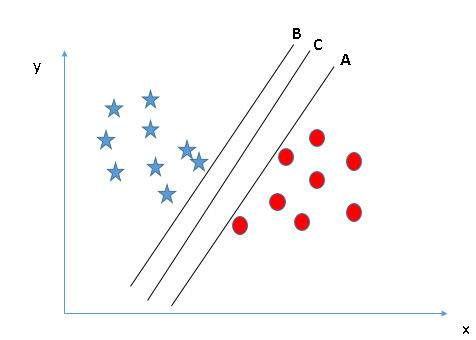
Figure Source:
https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/

As we all see here are 2 classes and they are seperated by a straight line, we we call they are linearly separable. When our dataset is classified in this way, we can say that we are using a Linear SVM Classification 

$\text{I.Soft Margin}$
In the figure above, we can say our margin (boundary) strictly classify the red circles and blue stars into 2 sets, and no blue stars can be in right side and no red circle can be in left side. So for this kind of SVM classification, we can say its margin is very hard.
Otherwise, if oure model is flexible to tolerate some outliers are misclassified, we can say our model become softer.

In our model, we switch our model's softness using the parameter $C$ when we create SVM object. The higher the $C$, the harder our margin become and the less the $C$, the softer our margin become

##### VMW Linear SVM SOFT MARGIN

In [100]:
from sklearn.svm import LinearSVC,SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

cols = ['EWMA5-10', 'EWMA3-5', 'EWMA3-10', 'EWMA5-20','MA3-5', 'MA5-10', 'MA5-20', 'MA3-10']

VMW_factors['Y'][VMW_factors['Y']<=0] = -1

#plot_logit_ROC(default_ind,Y_test,X_test,logit,Y_response,X_features)
X_Train_VMW, X_Test_VMW, Y_Train_VMW, Y_Test_VMW = model_selection.train_test_split(VMW_factors[cols],
                                                                                    VMW_factors['Y'] ,
                                                                                    test_size=0.6, shuffle=True)
SVM_VMW =SVC(C=1e5,probability=True)

SVM_VMW.fit(X_Train_VMW,Y_Train_VMW)
Y_VMW_P = SVM_VMW.predict(X_Test_VMW)

print("Confusion Matrix VMW in Soft Margin SVM")
print(pd.DataFrame(confusion_matrix(Y_VMW_P,Y_Test_VMW)))
print("Transition Prob for VMW Using SVM")
pd.DataFrame(SVM_VMW.predict_proba(X_Test_VMW)).head(5)

Confusion Matrix VMW in Soft Margin SVM
     0    1
0  200  243
1  193  243
Transition Prob for VMW Using SVM


0         1
0  0.487391  0.512609
1  0.500000  0.500000
2  0.494213  0.505787
3  0.493975  0.506025
4  0.483278  0.516722

In [101]:
print('         Support Vectors for VMW')
df = pd.DataFrame(SVM_VMW.support_vectors_)
df.columns = cols
df.head(3)

         Support Vectors for VMW


EWMA5-10   EWMA3-5  EWMA3-10  EWMA5-20     MA3-5  MA5-10     MA5-20  \
0  2.593730  1.270397  3.864127  5.872370  1.181333   3.298   7.263500   
1 -0.961513 -0.807279 -1.768791 -0.797667  0.499999  -1.898  -2.776499   
2 -2.470672 -0.280888 -2.751561 -7.049432  0.910000  -3.723 -10.870999   

     MA3-10  
0  4.479333  
1 -1.398000  
2 -2.813000

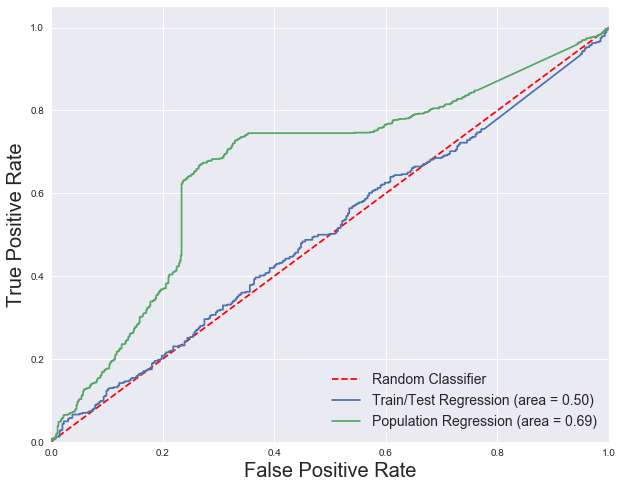

In [102]:
 plot_logit_ROC(1,Y_Test_VMW,X_Test_VMW,SVM_VMW,VMW_factors['Y'],VMW_factors[cols])

##### MSFT Linear SVM SOFT MARGIN

In [103]:
MSFT_factors['Y'][MSFT_factors['Y']<=0] = -1

#plot_logit_ROC(default_ind,Y_test,X_test,logit,Y_response,X_features)
X_Train_MSFT, X_Test_MSFT, Y_Train_MSFT, Y_Test_MSFT = model_selection.train_test_split(MSFT_factors[cols],
                                                                                    MSFT_factors['Y'] ,
                                                                                    test_size=0.6, shuffle=True)
SVM_MSFT =SVC(C=1e5,probability=True)

SVM_MSFT.fit(X_Train_MSFT,Y_Train_MSFT)
Y_MSFT_P = SVM_MSFT.predict(X_Test_MSFT)

print("Confusion Matrix VMW in Soft Margin MSFT")
print(pd.DataFrame(confusion_matrix(Y_MSFT_P,Y_Test_MSFT)))
print("Transition Prob for VMW Using MSFT")
pd.DataFrame(SVM_MSFT.predict_proba(X_Test_MSFT)).head(5)

Confusion Matrix VMW in Soft Margin MSFT
     0    1
0  202  243
1  199  235
Transition Prob for VMW Using MSFT


0         1
0  0.469379  0.530621
1  0.483102  0.516898
2  0.500000  0.500000
3  0.474765  0.525235
4  0.475808  0.524192

In [104]:
print('         Support Vectors for MSFT')
df = pd.DataFrame(SVM_MSFT.support_vectors_)
df.columns = cols
df.head(3)


         Support Vectors for MSFT


EWMA5-10   EWMA3-5  EWMA3-10  EWMA5-20     MA3-5    MA5-10    MA5-20  \
0  0.056046  0.138683  0.194729  0.247020  0.346666 -0.111000 -0.496000   
1  0.406777  0.025087  0.431863  2.110862  1.040668  0.331000  1.293000   
2 -3.114881 -2.113393 -5.228274 -5.885610 -2.886666 -3.329999 -6.716499   

     MA3-10  
0  0.235666  
1  1.371667  
2 -6.216665

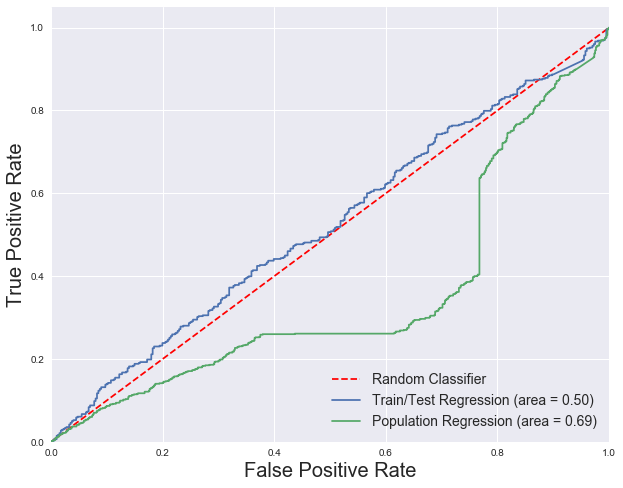

In [105]:
plot_logit_ROC(1,Y_Test_MSFT,X_Test_MSFT,SVM_MSFT,MSFT_factors['Y'],MSFT_factors[cols])

##### ORCL Linear SVM SOFT MARGIN

In [106]:
ORCL_factors['Y'][ORCL_factors['Y']<=0] = -1

#plot_logit_ROC(default_ind,Y_test,X_test,logit,Y_response,X_features)
X_Train_ORCL, X_Test_ORCL, Y_Train_ORCL, Y_Test_ORCL = model_selection.train_test_split(ORCL_factors[cols],
                                                                                    ORCL_factors['Y'] ,
                                                                                    test_size=0.6, shuffle=True)
SVM_ORCL =SVC(C=1e5,probability=True)

SVM_ORCL.fit(X_Train_ORCL,Y_Train_ORCL)
Y_ORCL_P = SVM_ORCL.predict(X_Test_ORCL)

print("Confusion Matrix VMW in Soft Margin ORCL")
print(pd.DataFrame(confusion_matrix(Y_ORCL_P,Y_Test_ORCL)))
print("Transition Prob for ORCL Using SVM")
pd.DataFrame(SVM_ORCL.predict_proba(X_Test_ORCL)).head(5)

Confusion Matrix VMW in Soft Margin ORCL
     0    1
0  193  224
1  210  252
Transition Prob for ORCL Using SVM


0         1
0  0.474409  0.525591
1  0.474489  0.525511
2  0.472357  0.527643
3  0.472878  0.527122
4  0.473669  0.526331

In [107]:
print('         Support Vectors for ORCL')
df = pd.DataFrame(SVM_ORCL.support_vectors_)
df.columns = cols
df.head(3) 

         Support Vectors for ORCL


EWMA5-10   EWMA3-5  EWMA3-10  EWMA5-20     MA3-5    MA5-10    MA5-20  \
0  1.238511  0.703441  1.941952  3.160590  0.573334  1.305999  3.287998   
1 -1.576978 -0.625685 -2.202663 -3.069913 -0.432000 -2.723001 -4.659000   
2  0.154698  0.217587  0.372284  0.325830  0.070667  0.097000  0.059500   

     MA3-10  
0  1.879333  
1 -3.155001  
2  0.167667

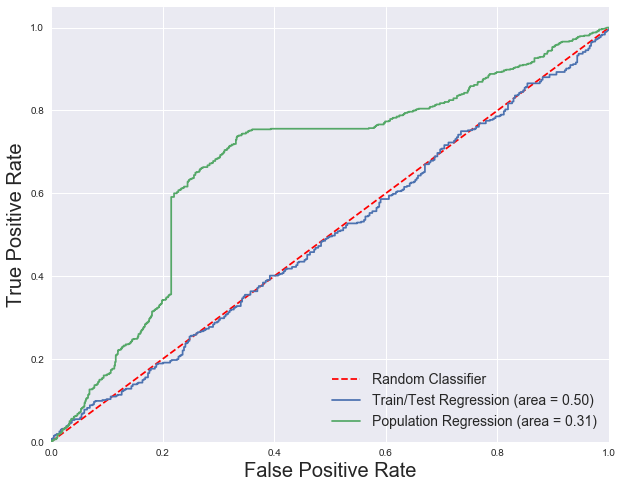

In [108]:
plot_logit_ROC(1,Y_Test_ORCL,X_Test_ORCL,SVM_ORCL,-ORCL_factors['Y'],ORCL_factors[cols])

$\text{II.Hard Margin}$

##### VMW SVM HardMargin

In [109]:
SVM_VMW =SVC(C=0.5,probability=True)
SVM_VMW.fit(X_Train_VMW,Y_Train_VMW)
Y_VMW_P = SVM_VMW.predict(X_Test_VMW)

print("Confusion Matrix VMW in Soft Margin SVM")
print(pd.DataFrame(confusion_matrix(Y_VMW_P,Y_Test_VMW)))
print("Transition Prob for VMW Using SVM")
pd.DataFrame(SVM_VMW.predict_proba(X_Test_VMW)).head(5)

Confusion Matrix VMW in Soft Margin SVM
     0    1
0   77  108
1  316  378
Transition Prob for VMW Using SVM


0         1
0  0.520772  0.479228
1  0.526906  0.473094
2  0.550154  0.449846
3  0.534045  0.465955
4  0.563672  0.436328

         Support Vectors for VMW


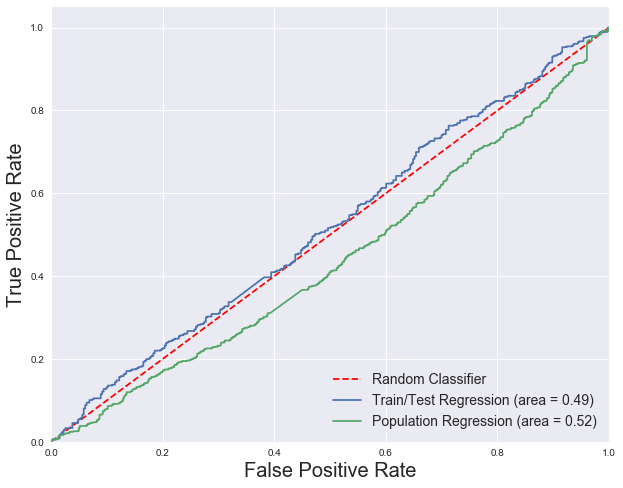

In [110]:
print('         Support Vectors for VMW')
df = pd.DataFrame(SVM_VMW.support_vectors_)
df.columns = cols
df.head(3)

plot_logit_ROC(1,Y_Test_VMW,X_Test_VMW,SVM_VMW,VMW_factors['Y'],VMW_factors[cols])

##### MSFT SVM HARD MARGIN

In [111]:
ORCL_factors['Y'][ORCL_factors['Y']<=0] = -1

#plot_logit_ROC(default_ind,Y_test,X_test,logit,Y_response,X_features)
X_Train_ORCL, X_Test_ORCL, Y_Train_ORCL, Y_Test_ORCL = model_selection.train_test_split(ORCL_factors[cols],
                                                                                    ORCL_factors['Y'] ,
                                                                                    test_size=0.6, shuffle=True)
SVM_ORCL =SVC(C=1,probability=True)

SVM_ORCL.fit(X_Train_ORCL,Y_Train_ORCL)
Y_ORCL_P = SVM_ORCL.predict(X_Test_ORCL)

print("Confusion Matrix VMW in Soft Margin MSFT")
print(pd.DataFrame(confusion_matrix(Y_ORCL_P,Y_Test_ORCL)))
print("Transition Prob for VMW Using SVM")
pd.DataFrame(SVM_ORCL.predict_proba(X_Test_ORCL)).head(5)

Confusion Matrix VMW in Soft Margin MSFT
     0    1
0   50   54
1  361  414
Transition Prob for VMW Using SVM


0         1
0  0.421248  0.578752
1  0.482323  0.517677
2  0.526071  0.473929
3  0.475132  0.524868
4  0.521869  0.478131

         Support Vectors for MSFT


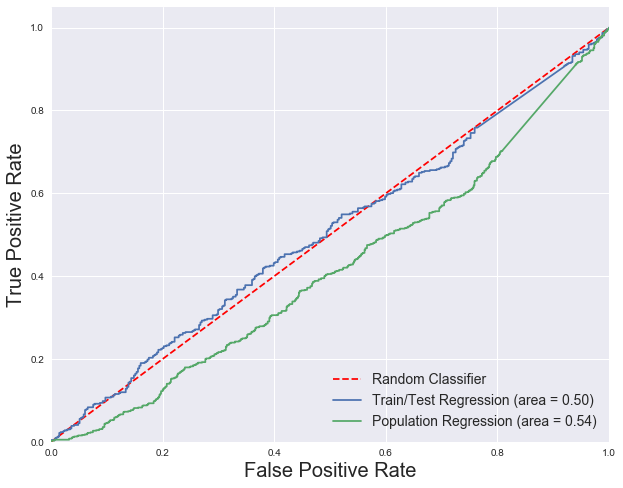

In [112]:
print('         Support Vectors for MSFT')
df = pd.DataFrame(SVM_ORCL.support_vectors_)
df.columns = cols
df.head(3)

plot_logit_ROC(1,Y_Test_ORCL,X_Test_ORCL,SVM_ORCL,ORCL_factors['Y'],ORCL_factors[cols])

##### ORCL SVM HARD MARGIN

In [113]:
                                                                                    
SVM_ORCL =SVC(C=0.5,probability=True)

SVM_ORCL.fit(X_Train_ORCL,Y_Train_ORCL)
Y_ORCL_P = SVM_ORCL.predict(X_Test_ORCL)

print("Confusion Matrix VMW in Soft Margin ORCL")
print(pd.DataFrame(confusion_matrix(Y_ORCL_P,Y_Test_ORCL)))
print("Transition Prob for ORCL Using SVM")
pd.DataFrame(SVM_ORCL.predict_proba(X_Test_ORCL)).head(5)

Confusion Matrix VMW in Soft Margin ORCL
     0    1
0   18   25
1  393  443
Transition Prob for ORCL Using SVM


0         1
0  0.443858  0.556142
1  0.487838  0.512162
2  0.515680  0.484320
3  0.484576  0.515424
4  0.518937  0.481063

         Support Vectors for ORCL


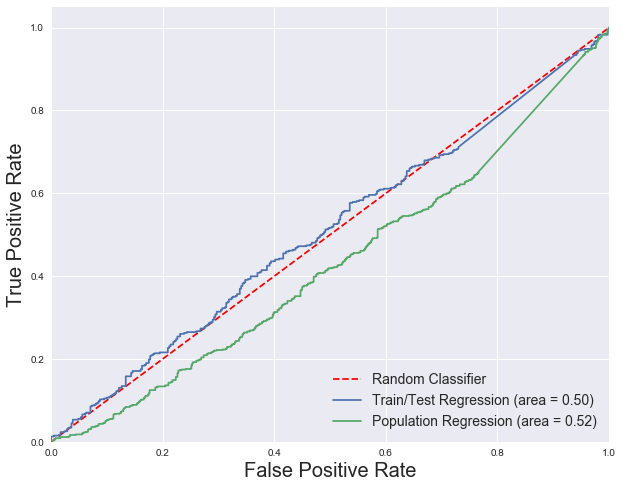

In [114]:
print('         Support Vectors for ORCL')
df = pd.DataFrame(SVM_ORCL.support_vectors_)
df.columns = cols
df.head(3)

plot_logit_ROC(1,Y_Test_ORCL,X_Test_ORCL,SVM_ORCL,ORCL_factors['Y'],ORCL_factors[cols])

$\text{III Analysis}$

Now we get all the results of SVM model either in hard margin or soft margin on 3 stocks, we find:

1. As the margin increases, or becomes softer, our model becomes more accurate on population data
2. Though soft margin model performs good in population data, but its accuracy decreases quickly when it is used to backtest the testing set, it means that here may be overfitting in soft margin model
3. I also print the support vectors, and there is no suprised that all the features, after the SVM Model's transformation, now are under the same scale 

##### 1.4.3 Polynomial Kernel SVM

If datasets are linearly seperable, there is not surprise that we use Linear SVM Classification, but actually in our real world, not all the data can be seperated using linear classification techniques. So we need to add some new features, which are made by the old features we had. 

For clear, we can understand it using the figure below:
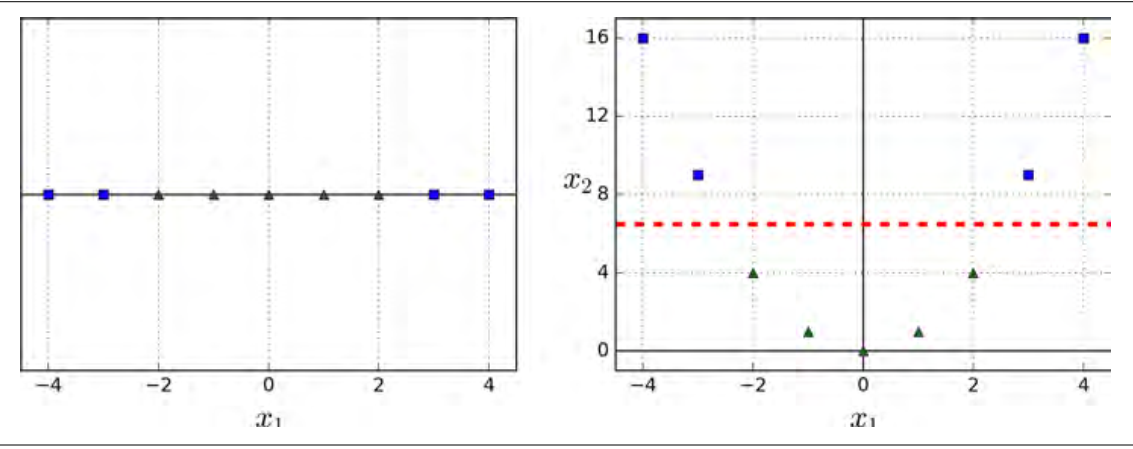
Figure Source: https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291/ref=sr_1_3?crid=I8WMCRXX5N4U&keywords=machine+learning&qid=1561431575&s=gateway&sprefix=machine+lear%2Caps%2C133&sr=8-3

As we can see, in the left plot, blue squares and grey triangles are not be able to seperated. But what if we square them? Them amazing stories occurs, and you can say that in the right side, blue squares and green triangles are separated.

#### 1.5 Decision Tree and Ensemble Methods
##### 1.5.1 Introduction 
$\text{Decision Trees}$ are a supervised-learning technique. We can imagine them as flowchars, and we classify our samples according to their numerical or categorical attributes. Let us use a figure to figure it out:

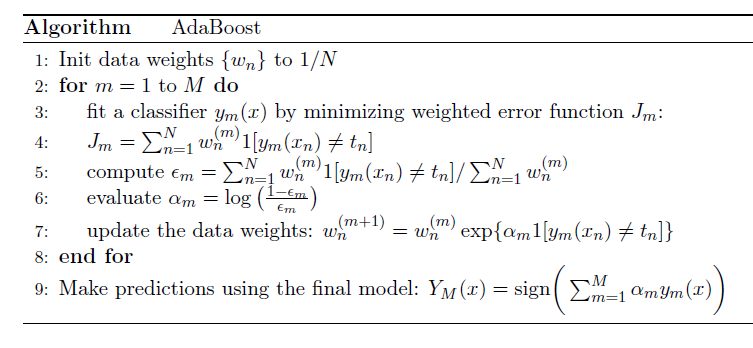

To better introduce what is the decision tree, we need to clarify the definition of followings:

1.Root Node: The entire population or sample which will be further divided into two or more categories

2.Splitting: The process of dividing a node into two or more

3.Decision Node: The node on which a subnode will splitted out

4.Leaf/Terminal Node: Nodes that do not have any subnode

5.Branch: A subsection of entire tree

6.Parent and Child Node: A node which is divided into sub-nodes is called parent node wheras the sub-nodes are child of parent node

Before we deep into decision tree, we can first summarize the advantages and disadvantages of Decision Tree:

1.Simple statistical and mathematical background

2.Fast to explore the significant variables and relation betweem two or more variables, based on which we can better predict our target variable.

3.Little effort for data preparation and cleaning

4.Get rid of data type: both numerical and non-numerical features can be used

5.Non-Parametric Method: We do not need to assume the distribution of features and the classifier structure

6.The non-linear relationship does not influence the model performance

Disadvantage:

1.This model will easily lead to overfitting

2.Data processing for non-numeric data is difficult

3.The tree may be very big

$\text{Ensemble methods}\ $can be a very strong algorithm which combines several machine learning techniques into one predictive model in order to decrease variance, bias or improve prediction. Generally here are 2 main types of ensemble methods:
1. Sequential Ensemble Methods: The basic motivation of this method is to exploit the dependence between the base learner. To improve the model performance, we need to give larger weight to those samples mispredicted before

2. Parallel Ensemble Methods: The basic motivation of this method is to exploit independence between the base learners since the error can be reduced dramatically by averaging.

And Ensemble methods can also be classified into different types based on the type of base learner they use. If an ensemble method is based on only one kind of model, such as our metioned Decison Tree Model, we call our Ensemble method to be $\text{homogeneous}$ learner. If an ensemble method is based on multiple types of models, such as combining Logistic Regression Model with the Decision Tree model, we can our method to be $\text{heterogenous}$ model.

Usually in order to improve our ensemble method, we have a technique called Bagging, or called Boostrap aggregation. For example, if we want to reduce the variance of estimate, we can average together multiple estimate.

$$f(x) =\frac{1}{M} \sum_{m=1}^{M}f_{m}(x)$$


So how to we combine Decision model with ensemble learning? Here I list the key steps:

(1) Construct sample sets with replacement. Please remember that we need to select multiple subsets from all features with replacement.This is a key step fpr boostrap

(2) Construct deicision tree for each subsets of features

(3) Average all the trees to get our overall better model

$\text{Boosting}$ is one another techinique usually used with decision tree. This is an effective method converting a weak learner to be a strong learner. The key point of this model is to fit a sequence of weak models, which is only little more accurate than random model, to a weighted versions of the data. More weight will be given to examples that were missclassifed by earlier rounds. 

We have 2 ways to combine models, one is called majority vote and another one is called weighted sum. And here is a significant difference between bagging and boosting, that the base learners are trained in a sequence on a weighted version of the data while the base learners are randomly sampled in boosting methods.

$\text{AdaBoost}$ is the most popular boosting algorithm. It has pseudo code like follows:

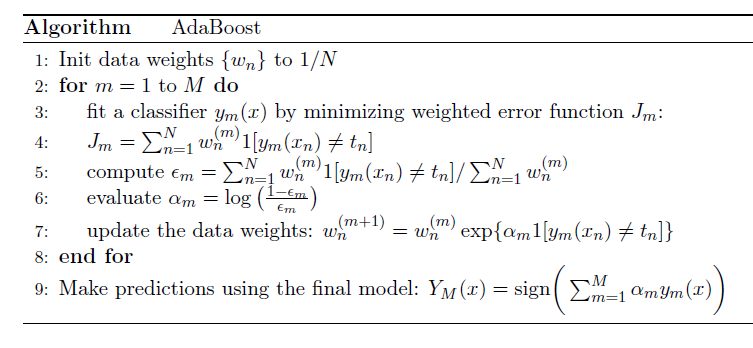

###### figure source https://blog.statsbot.co/ensemble-learning-d1dcd548e936

We can find that at our first classifier is assigned with equal weight coefficient but later the coefficients increases for that data that are misclassified and decreased for data points that are not correctly classified.

For better explain the models, let us code to make it clear

$\text{I .Decision Tree Regressor}$

##### 1.5.2 Implementation

$\text {Decision Tree Regressor}$

##### Fit Decision Tree Regressor

In [115]:
###We first make a Decision Regressor for play
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

cols = ['ret_1',
       'ret_2', 'ret_3', 'ret_4', 'ret_5', 'MOM11',
       'MOM22', 'MOM66', 'MOM125', 
       'EWMA5-10', 'EWMA3-5', 'EWMA3-10', 'EWMA5-20', 'MA3-5', 'MA5-10', 'MA5-20', 'MA3-10']

###Divide data into Train set and Testing set
X_Train_VMW, X_Test_VMW, Y_Train_VMW, Y_Test_VMW = model_selection.train_test_split(VMW_factors[cols],
                                                                                    VMW_factors['Sign0'] ,
                                                                                    test_size=0.6, shuffle=True)

Y_Test_VMW[Y_Test_VMW==0] = -1
Y_Train_VMW[Y_Train_VMW==0] = -1

###Create a simple decision tree model
tree_VMW = DecisionTreeRegressor(max_depth = 5)

###Create an AdaBooster on Decision Tree
ada_VMW = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 5),n_estimators=300,random_state=np.random.RandomState(1))

tree_VMW.fit(X_Train_VMW,Y_Train_VMW)
ada_VMW.fit(X_Train_VMW,Y_Train_VMW)


Y_VMW_tree = tree_VMW.predict(X_Test_VMW)
Y_VMW_ada = ada_VMW.predict(X_Test_VMW)

##### Visualize Decision Tree Regressor

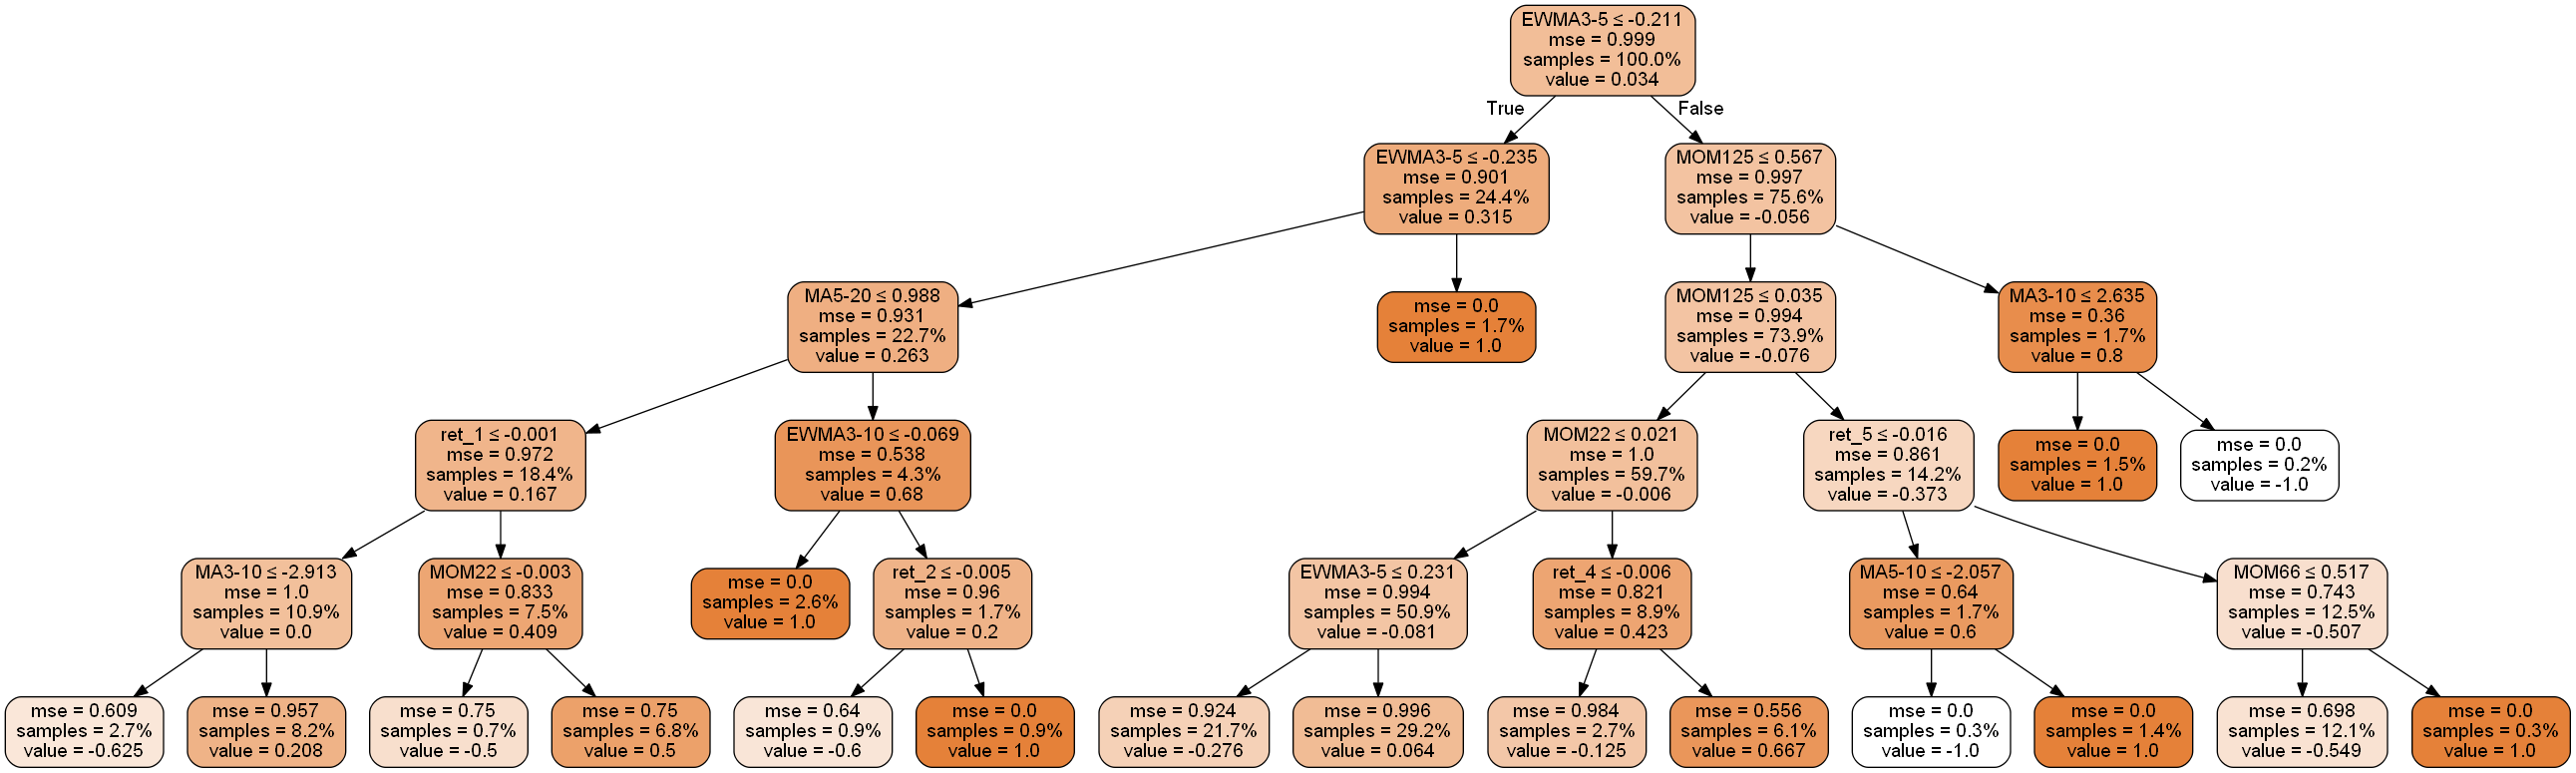

In [116]:
import graphviz
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image 
from sklearn.externals.six import StringIO  
#From ipython.display import Image

dot_data = StringIO()
export_graphviz(tree_VMW, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=cols,proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

$\text{II. Decision Tree Classifier}$

##### Fit Decision Tree Classifier
Now let us turn to our Decision Tree Classifier and Random Forest Classifier, which is our today's focus

In [132]:
from sklearn.tree import DecisionTreeClassifier

##Fit into Decision Classifier
tree_VMW =  DecisionTreeClassifier(random_state=np.random.RandomState(1))
tree_VMW.fit(X_Train_VMW,Y_Train_VMW)

tree_VMW_pred = tree_VMW.predict(X_Test_VMW)
pd.DataFrame(tree_VMW.predict_proba(X_Train_VMW)).head(3)

0    1
0  0.0  1.0
1  1.0  0.0
2  1.0  0.0

In [136]:
pd.DataFrame(confusion_matrix(tree_VMW_pred,Y_Test_VMW))

0    1
0  199  246
1  198  236

##### Visualize Decision Tree Classifier

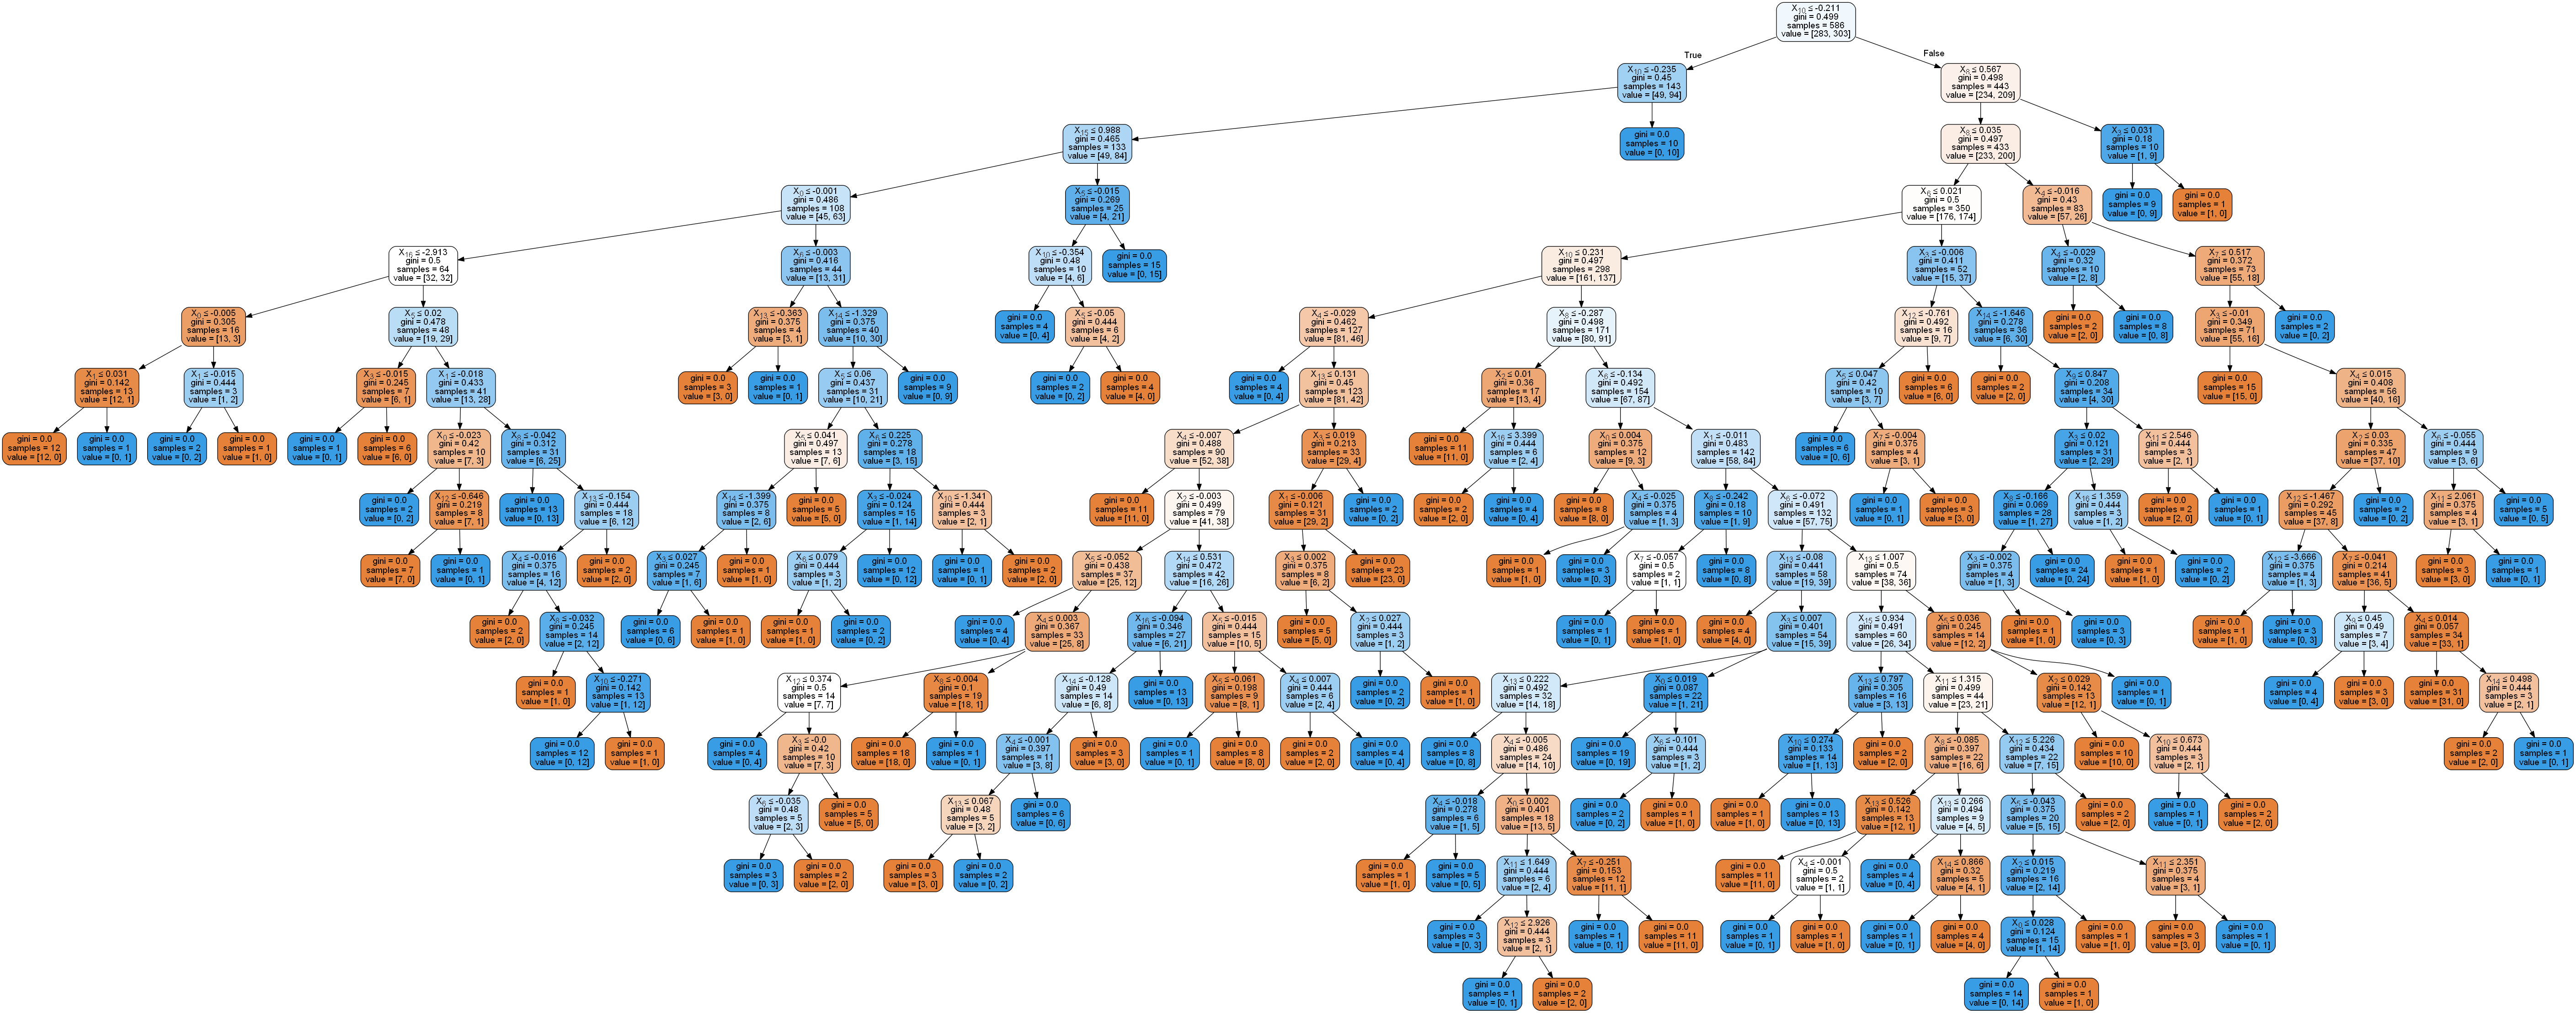

In [134]:
dot_data = StringIO()
export_graphviz(tree_VMW, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

$\text{III. Decision Tree Classifier with AdaBoostClassifier}$

In [137]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_VMW = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 4),algorithm = 'SAMME',n_estimators=200)

ada_VMW.fit(X_Train_VMW,Y_Train_VMW)

ada_VMW_pred = ada_VMW.predict(X_Test_VMW)

print("Confusion Matrix")
print(pd.DataFrame(confusion_matrix(ada_VMW_pred,Y_Test_VMW)).head(2))

print("Transition Prob")
print(pd.DataFrame(ada_VMW.predict_proba(X_Test_VMW)).head(3))

Confusion Matrix
     0    1
0  176  225
1  221  257
Transition Prob
          0         1
0  0.494332  0.505668
1  0.492948  0.507052
2  0.504760  0.495240


##### 1.5.3 Analysis

As we can see, all the three algorithm cannot give us a significant potential to get excess return on stocks. Our winning probability is usually near to the random model. However, compared to Simple Decision Tree Regressor and Simple Decision Tree Classifier, our Decision Tree Classifier with Adabooster indeed improve accuracy of prediction.

If we study the transition probability of models, we will also find that the likelihood for each transition is also not determinant.

#### Reference
[1] Andrew Ng, Stanford University CS229 Notes http://cs229.stanford.edu/notes-spring2019/cs229-notes1.pdf

[2] ET Jaynes, Probability Theory: The Logic of Science  https://www.amazon.com/Probability-Theory-Science-T-Jaynes/dp/0521592712/ref=sr_1_1?crid=1OMSTNUGHLPNJ&keywords=probability+theory+the+logic+of+science&qid=1560988932&s=gateway&sprefix=Probability+Theory%3A+The%2Caps%2C129&sr=8-1

[3]Wikepedia Cross Validation (Statistics) https://en.wikipedia.org/wiki/Cross-validation_(statistics)

[4]Springer, Encyclopedia of System Biology https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-9863-7_255

[5]Data Driven Investor https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833

[6]Max Kuhn & Kjell Johnson, Applied Predictive Modeling, https://www.amazon.com/Applied-Predictive-Modeling-Max-Kuhn/dp/1461468485/ref=sr_1_1?crid=2SLC5RI2D4GWZ&keywords=applied+predictive+modelling&qid=1561144037&s=gateway&sprefix=Applied+Pred%2Caps%2C124&sr=8-1

[7]James Douglas Hamilton , Time Series Analysis,https://www.amazon.com/Time-Analysis-James-Douglas-Hamilton/dp/0691042896/ref=sr_1_3?crid=3096JXSSH4H0F&keywords=time+series+analysis&qid=1561254911&s=gateway&sprefix=time+se%2Caps%2C129&sr=8-3

[8]Aurélien Géron, Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems 1st Edition https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291/ref=sr_1_3?crid=I8WMCRXX5N4U&keywords=machine+learning&qid=1561431575&s=gateway&sprefix=machine+lear%2Caps%2C133&sr=8-3

[9]Machine Learning 101, https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72

[10]Medium Machine Learning, https://medium.com/greyatom/decision-trees-a-simple-way-to-visualize-a-decision-dc506a403aeb

[11]Ensemble Learning https://blog.statsbot.co/ensemble-learning-d1dcd548e936

In [138]:

import io

from IPython.nbformat import current


filepath = 'C:/Users/38516/CQF/Project.ipynb'
with io.open(filepath, 'r', encoding='utf-8') as f:

    nb = current.read(f, 'json')



word_count = 0

for cell in nb.worksheets[0].cells:

    if cell.cell_type == "markdown":

        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print(word_count)

7614
